# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("ANTHROPIC")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
# from vanna.google import GoogleGeminiChat
from vanna.anthropic import Anthropic_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = "claude-3-5-sonnet-20241022"  # "claude-3-sonnet-20240229"
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, Anthropic_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Anthropic_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model claude-3-5-sonnet-20241022 for 694.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) 
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) 
FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model claude-3-5-sonnet-20241022 for 161.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['COUNT(*)'].iloc[0],
    title = {"text": "Total Number of Customers"}
))

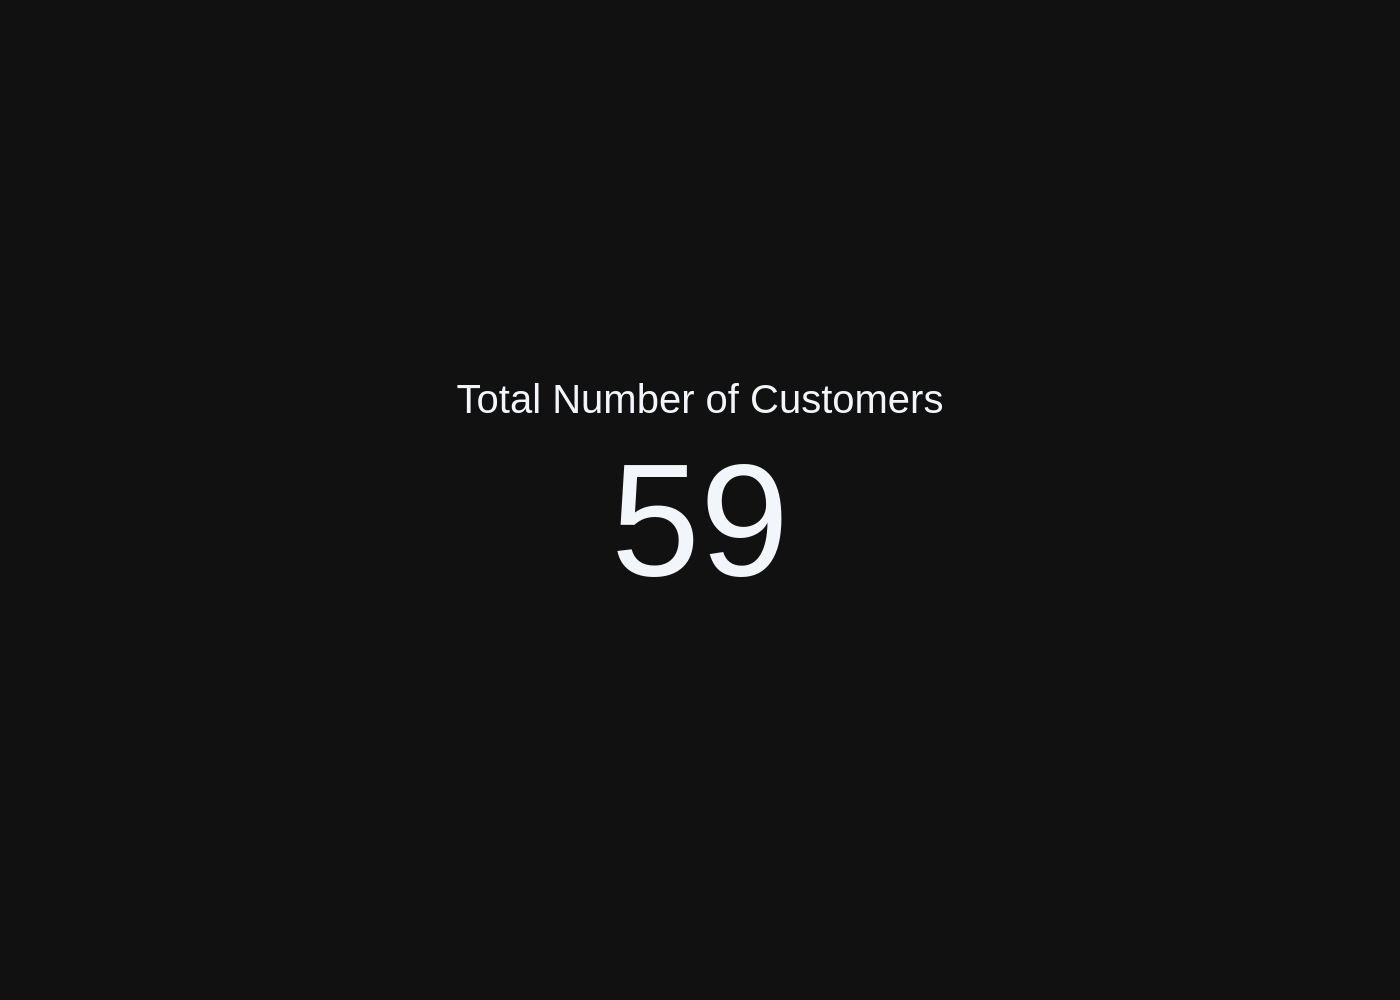

elapsed_time = 4.238252639770508


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model claude-3-5-sonnet-20241022 for 701.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT name 
FROM sqlite_master 
WHERE type='table'


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists


Using model claude-3-5-sonnet-20241022 for 172.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = len(df),
    title = {"text": "Number of Tables"}
))

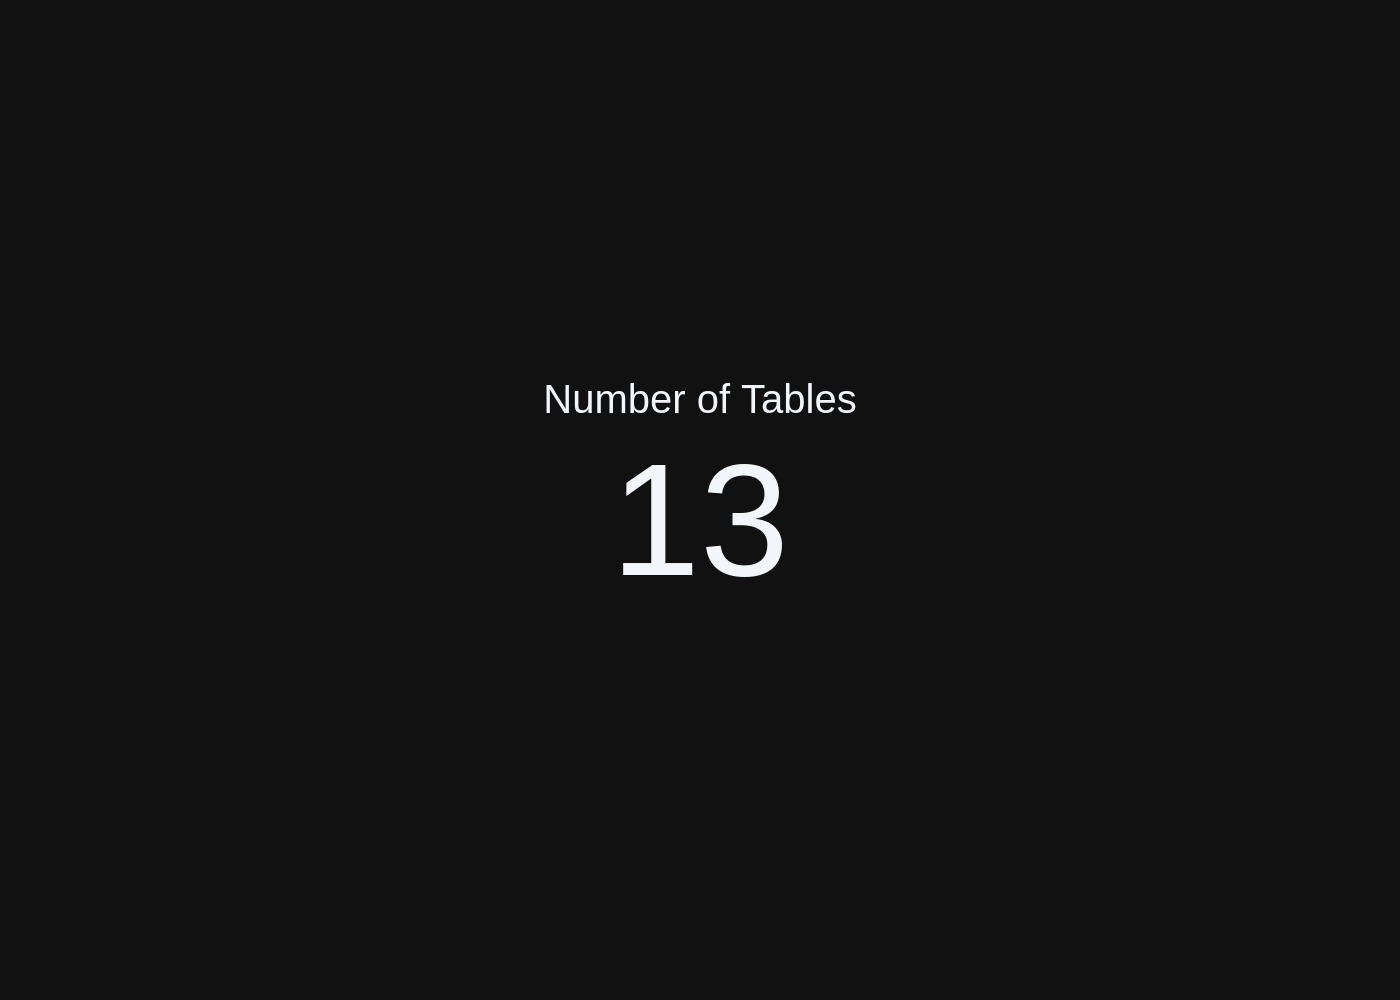





# QUESTION  - 3:  which table stores customer's orders


Using model claude-3-5-sonnet-20241022 for 735.25 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-5-sonnet-20241022 for 850.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT 'invoices' as table_name 
FROM sqlite_sequence 
LIMIT 1


[( <DataFrame> )]
queried dataframe



,table_name
0,invoices


Using model claude-3-5-sonnet-20241022 for 274.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = 1,
    title = {'text': "Table Storing Customer Orders"},
    gauge = {'axis': {'range': [0, 1]},
             'steps': [{'range': [0, 1], 'color': "lightgray"}],
             'bar': {'color': "darkblue"}},
    domain = {'x': [0, 1], 'y': [0, 1]}
))

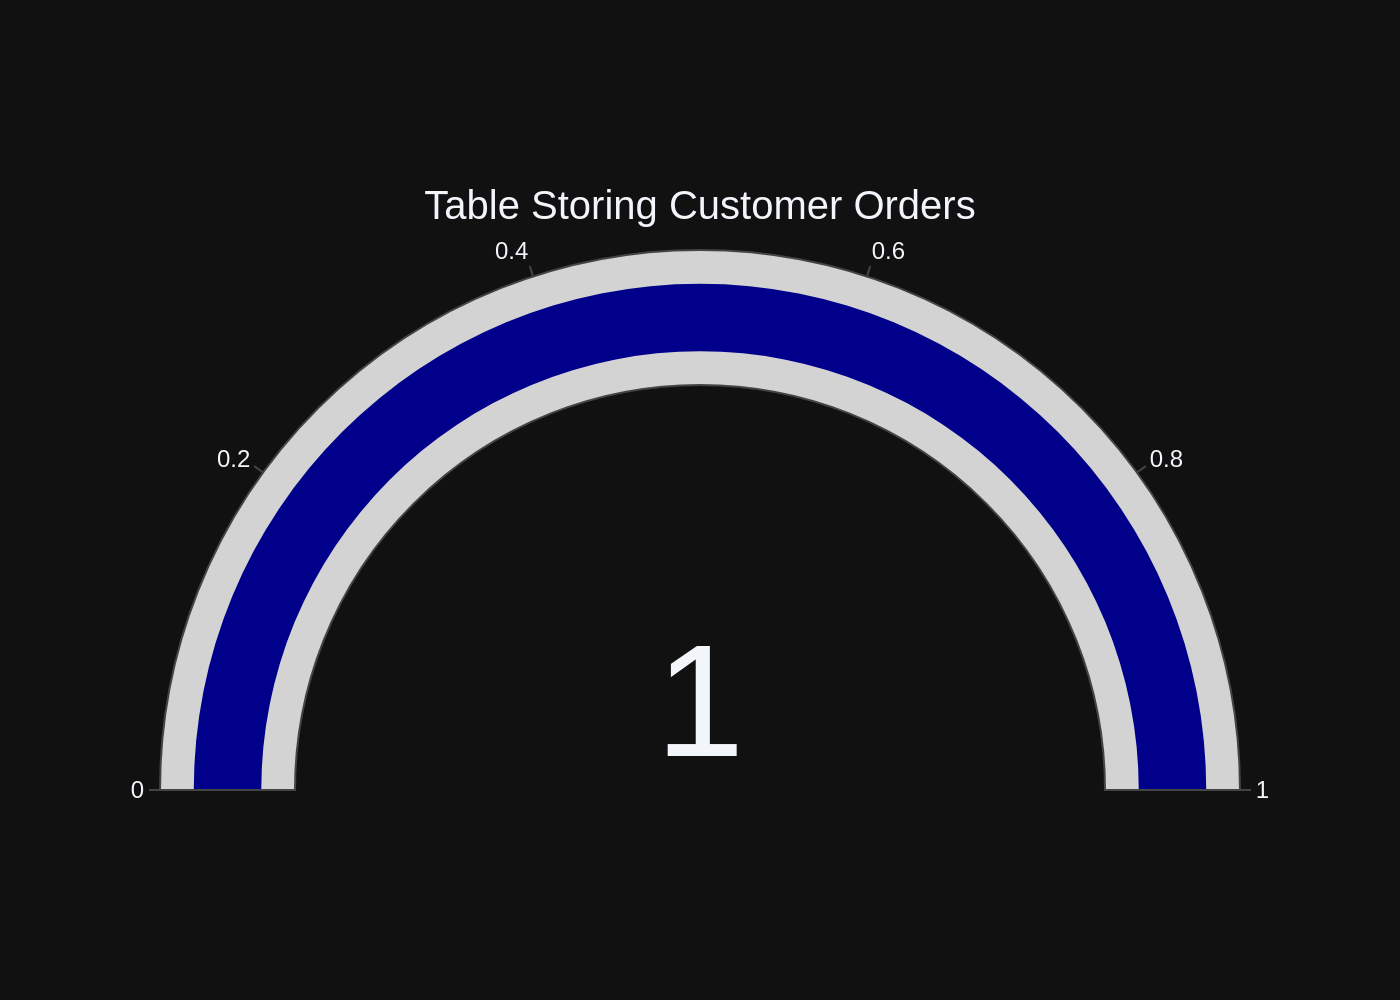





# QUESTION  - 4:  How many customers are there


Using model claude-3-5-sonnet-20241022 for 868.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT COUNT(*) 
FROM customers


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model claude-3-5-sonnet-20241022 for 161.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['COUNT(*)'].iloc[0],
    title = {"text": "Total Number of Customers"}
))

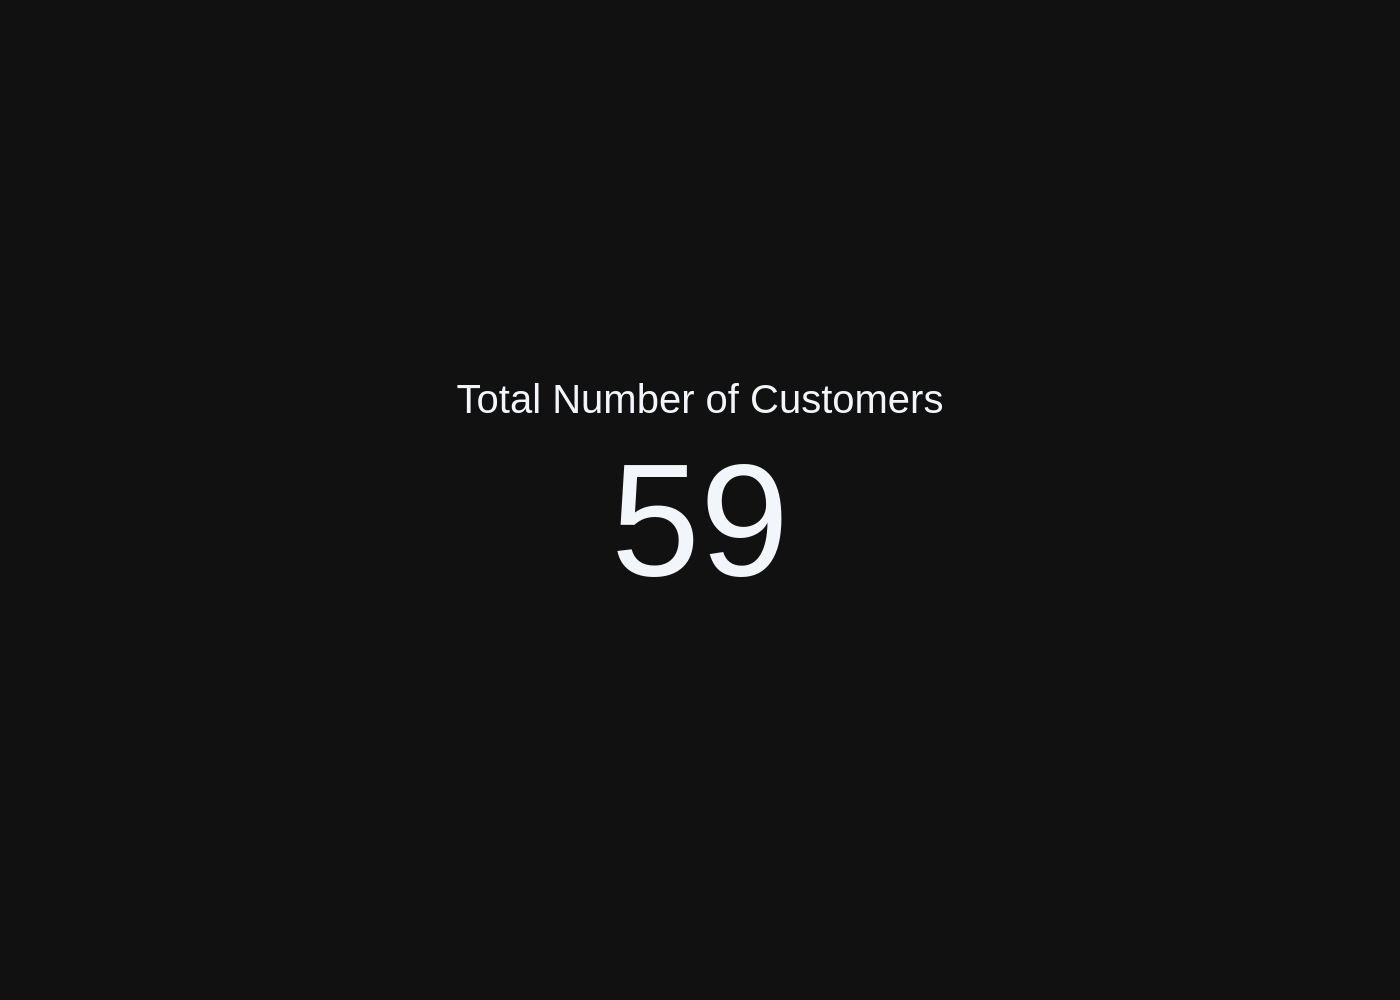





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model claude-3-5-sonnet-20241022 for 876.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Country, COUNT(*) as customer_count
FROM customers
GROUP BY Country
ORDER BY customer_count DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,Country,customer_count
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model claude-3-5-sonnet-20241022 for 193.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Country', y='customer_count', 
             title='Top 5 Customer Countries',
             labels={'customer_count': 'Number of Customers'})
fig.update_layout(xaxis_title='Country',
                 yaxis_title='Number of Customers')

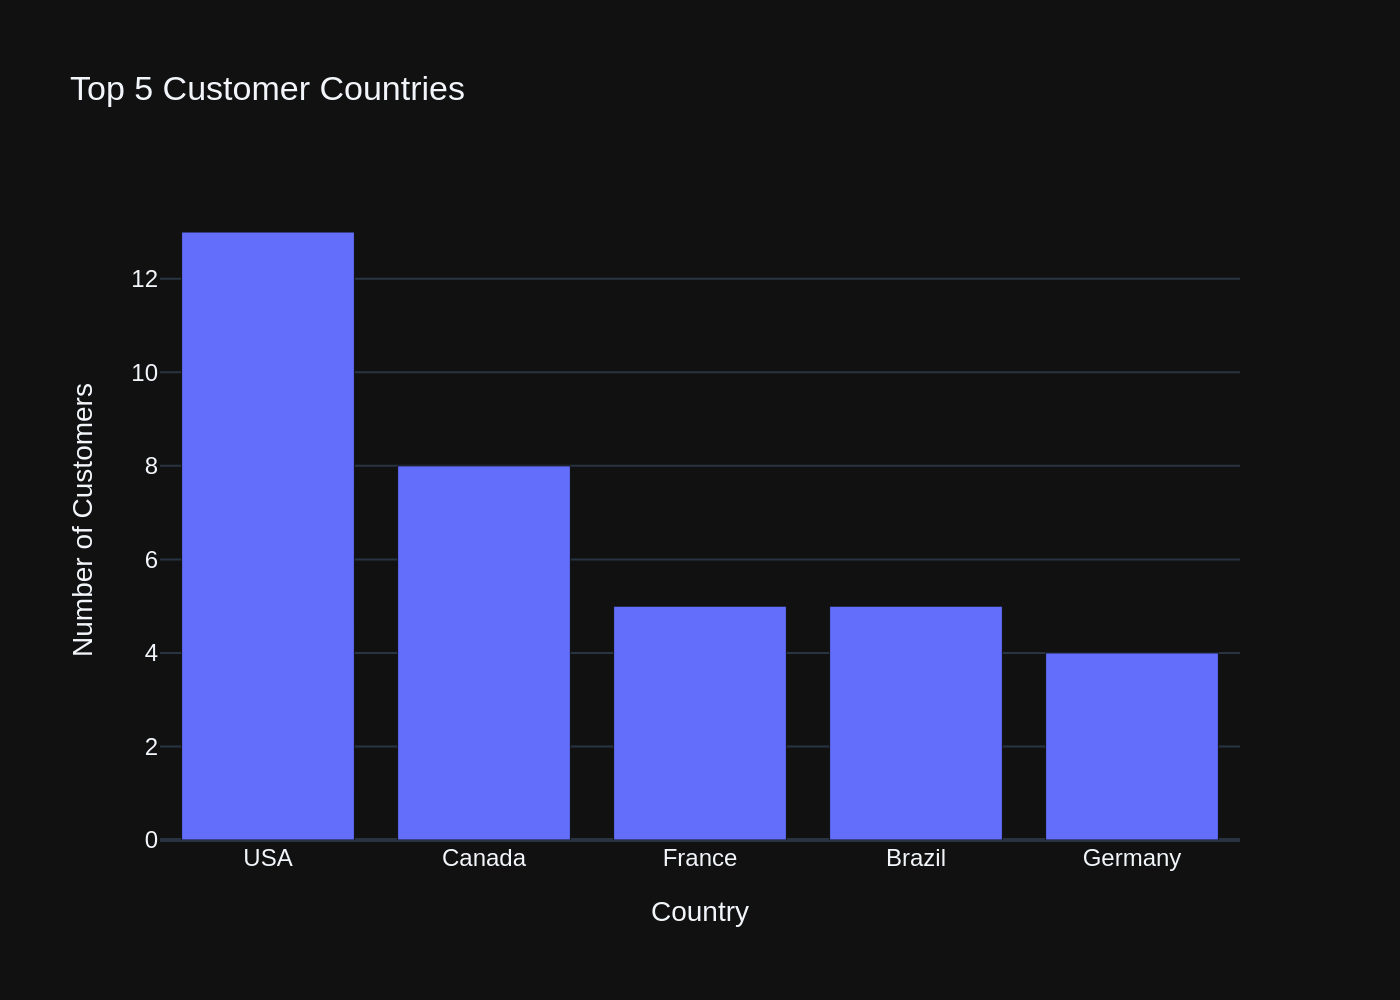





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model claude-3-5-sonnet-20241022 for 875.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT a.Title as album_title, ar.Name as artist_name 
FROM albums a 
JOIN artists ar ON a.ArtistId = ar.ArtistId


[( <DataFrame> )]
queried dataframe



,album_title,artist_name
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave


Using model claude-3-5-sonnet-20241022 for 195.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='artist_name', y='album_title', title='Albums by Artist')
fig.update_layout(xaxis_title='Artist', yaxis_title='Album')
fig.update_xaxis(tickangle=45)

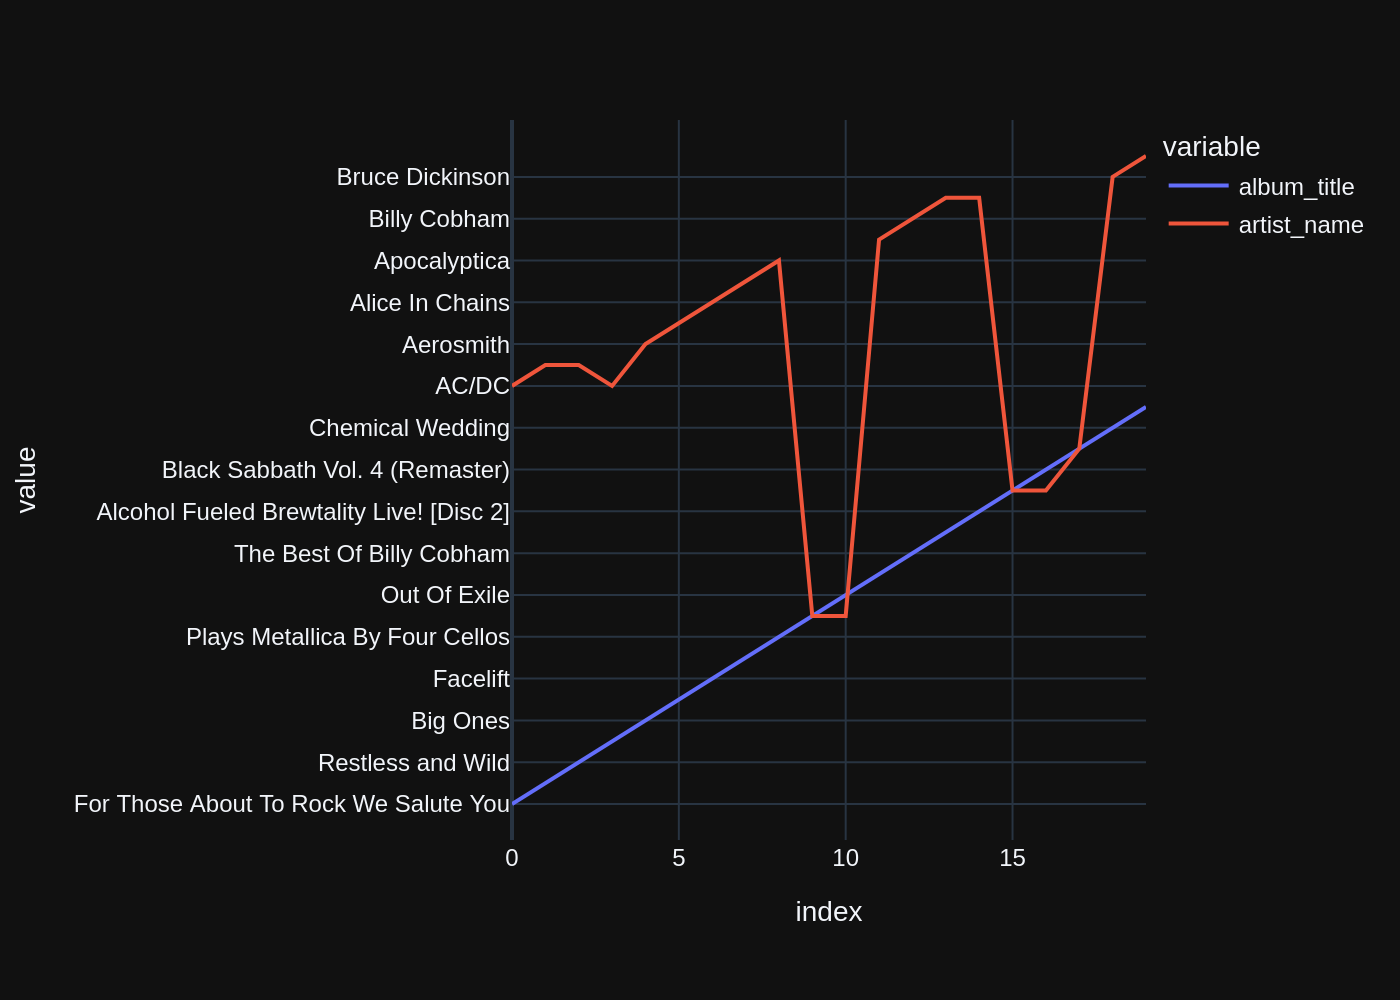





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model claude-3-5-sonnet-20241022 for 942.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Name 
FROM tracks 
WHERE UPPER(Name) LIKE '%WHAT%'


[( <DataFrame> )]
queried dataframe



,Name
0,What It Takes
1,What You Are
2,Do what cha wanna
3,What is and Should Never Be
4,So What
5,What A Day
6,What If I Do?
7,What Now My Love
8,Whatsername
9,"Whatever It Is, I Just Can't Stop"


Using model claude-3-5-sonnet-20241022 for 176.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = len(df),
    title = {'text': "Tracks Containing 'What'"},
    gauge = {'axis': {'range': [0, len(df)*1.5]}}
))

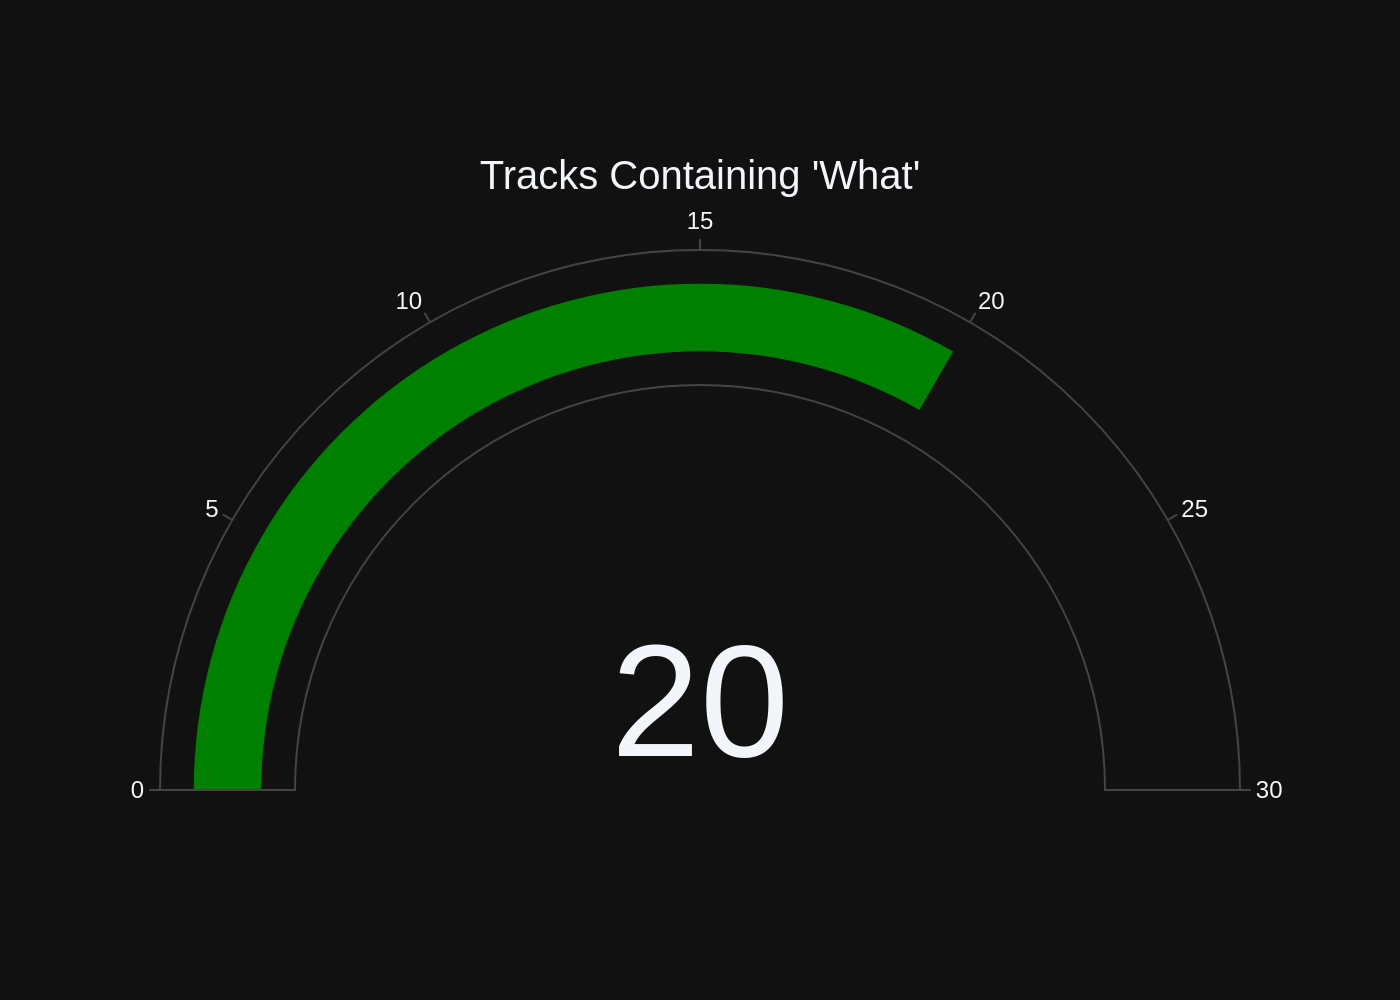





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model claude-3-5-sonnet-20241022 for 992.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       COUNT(i.InvoiceId) as total_invoices
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_invoices DESC


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_invoices
0,1,Luís,Gonçalves,7
1,2,Leonie,Köhler,7
2,3,François,Tremblay,7
3,4,Bjørn,Hansen,7
4,5,František,Wichterlová,7
5,6,Helena,Holý,7
6,7,Astrid,Gruber,7
7,8,Daan,Peeters,7
8,9,Kara,Nielsen,7
9,10,Eduardo,Martins,7


Using model claude-3-5-sonnet-20241022 for 242.5 tokens (approx)

[( <Python> )]
generated Plotly code



fig = px.bar(df, 
             x='CustomerId', 
             y='total_invoices',
             hover_data=['FirstName', 'LastName'],
             title='Total Invoices by Customer',
             labels={'CustomerId': 'Customer ID', 
                    'total_invoices': 'Total Invoices'})

fig.update_layout(
    xaxis_title="Customer ID",
    yaxis_title="Number of Invoices",
    showlegend=False
)

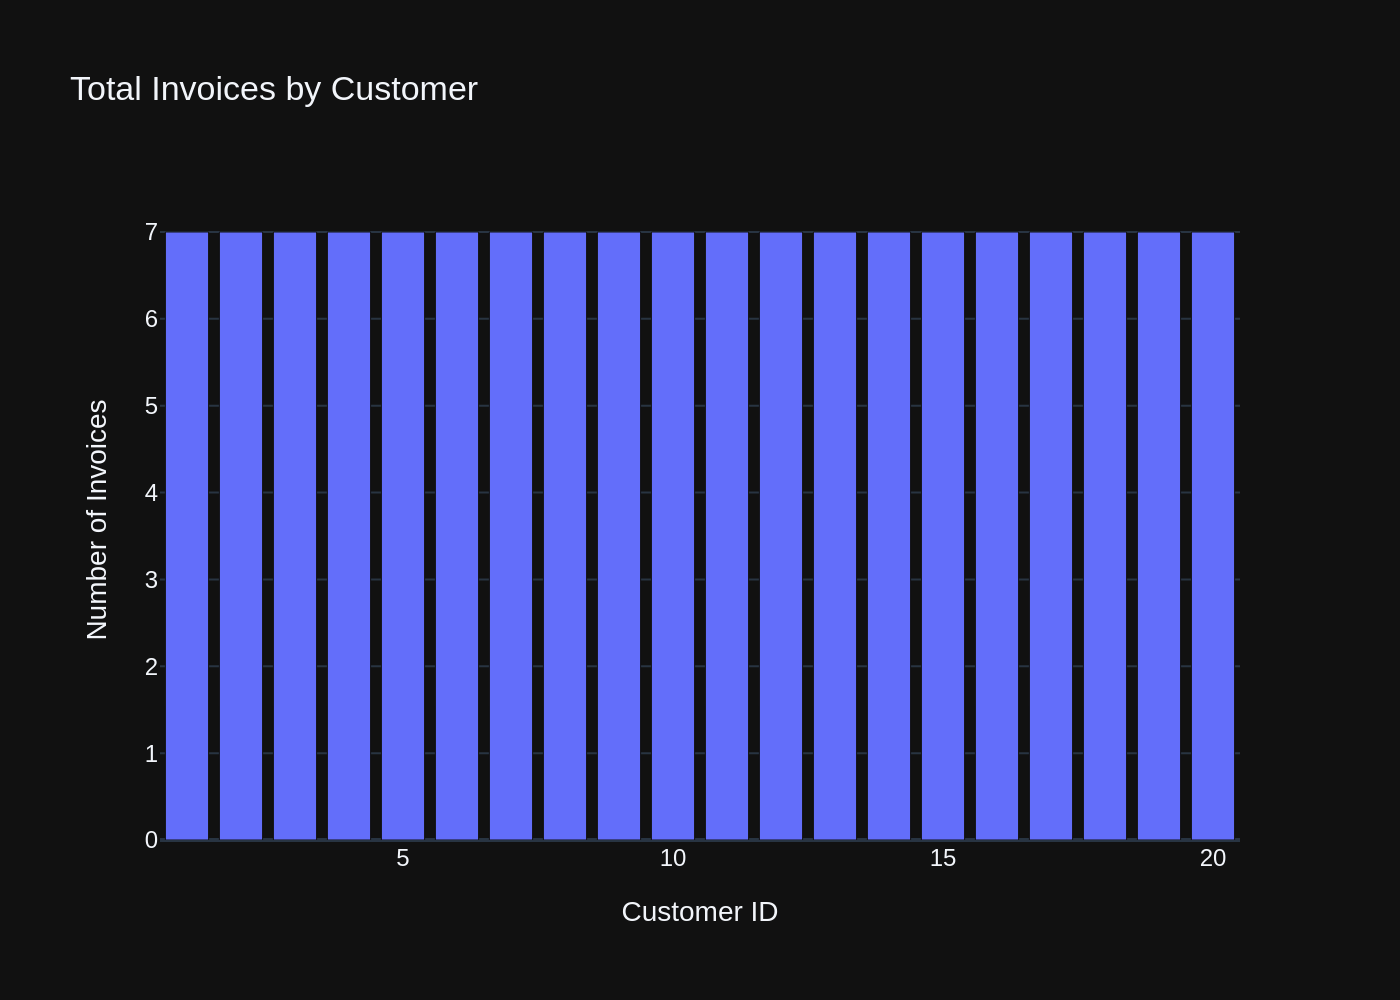





# QUESTION  - 9:  Find the total number of invoices per country


Using model claude-3-5-sonnet-20241022 for 1074.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) as invoice_count
FROM invoices
GROUP BY BillingCountry
ORDER BY invoice_count DESC LIMIT 20


[( <DataFrame> )]
queried dataframe



,BillingCountry,invoice_count
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28
5,United Kingdom,21
6,Portugal,14
7,Czech Republic,14
8,India,13
9,Sweden,7


Using model claude-3-5-sonnet-20241022 for 194.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='BillingCountry', y='invoice_count', 
             title='Total Number of Invoices by Country',
             labels={'invoice_count': 'Number of Invoices', 
                    'BillingCountry': 'Country'})
fig.update_layout(showlegend=False)

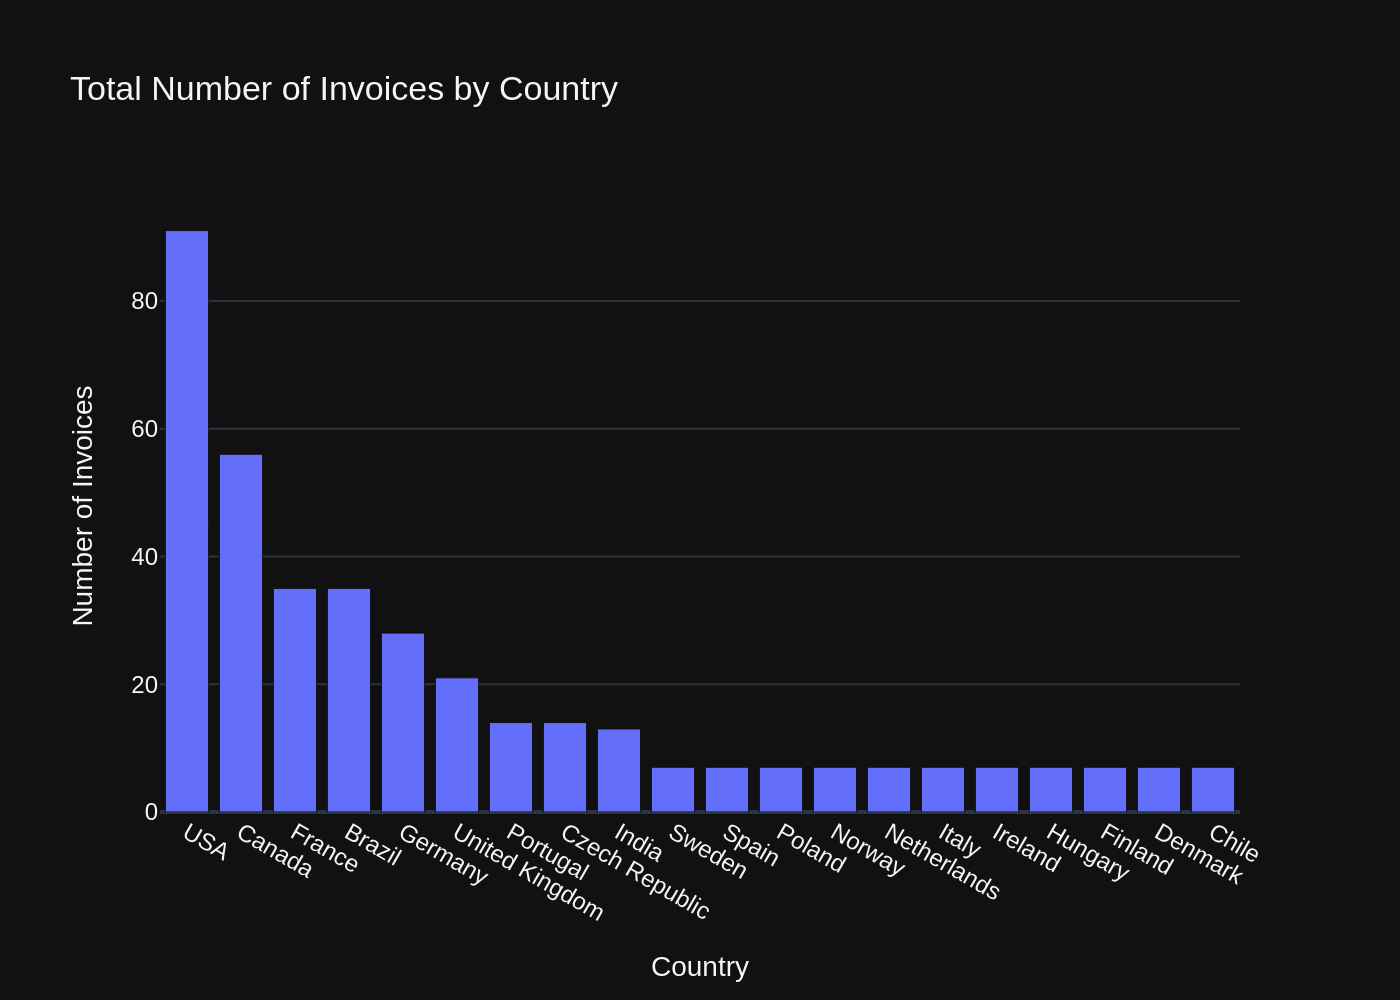





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model claude-3-5-sonnet-20241022 for 1116.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT InvoiceId, CustomerId, InvoiceDate, Total
FROM invoices 
WHERE Total > 10
ORDER BY Total DESC LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,Total
0,404,6,2013-11-13 00:00:00,25.86
1,299,26,2012-08-05 00:00:00,23.86
2,96,45,2010-02-18 00:00:00,21.86
3,194,46,2011-04-28 00:00:00,21.86
4,89,7,2010-01-18 00:00:00,18.86
5,201,25,2011-05-29 00:00:00,18.86
6,88,57,2010-01-13 00:00:00,17.91
7,306,5,2012-09-05 00:00:00,16.86
8,313,43,2012-10-06 00:00:00,16.86
9,103,24,2010-03-21 00:00:00,15.86


Using model claude-3-5-sonnet-20241022 for 201.25 tokens (approx)

[( <Python> )]
generated Plotly code



fig = px.scatter(df, x='InvoiceDate', y='Total', 
                          hover_data=['InvoiceId', 'CustomerId'],
                          title='Invoices Exceeding $10')
fig.update_layout(
    xaxis_title="Invoice Date",
    yaxis_title="Total Amount ($)"
)

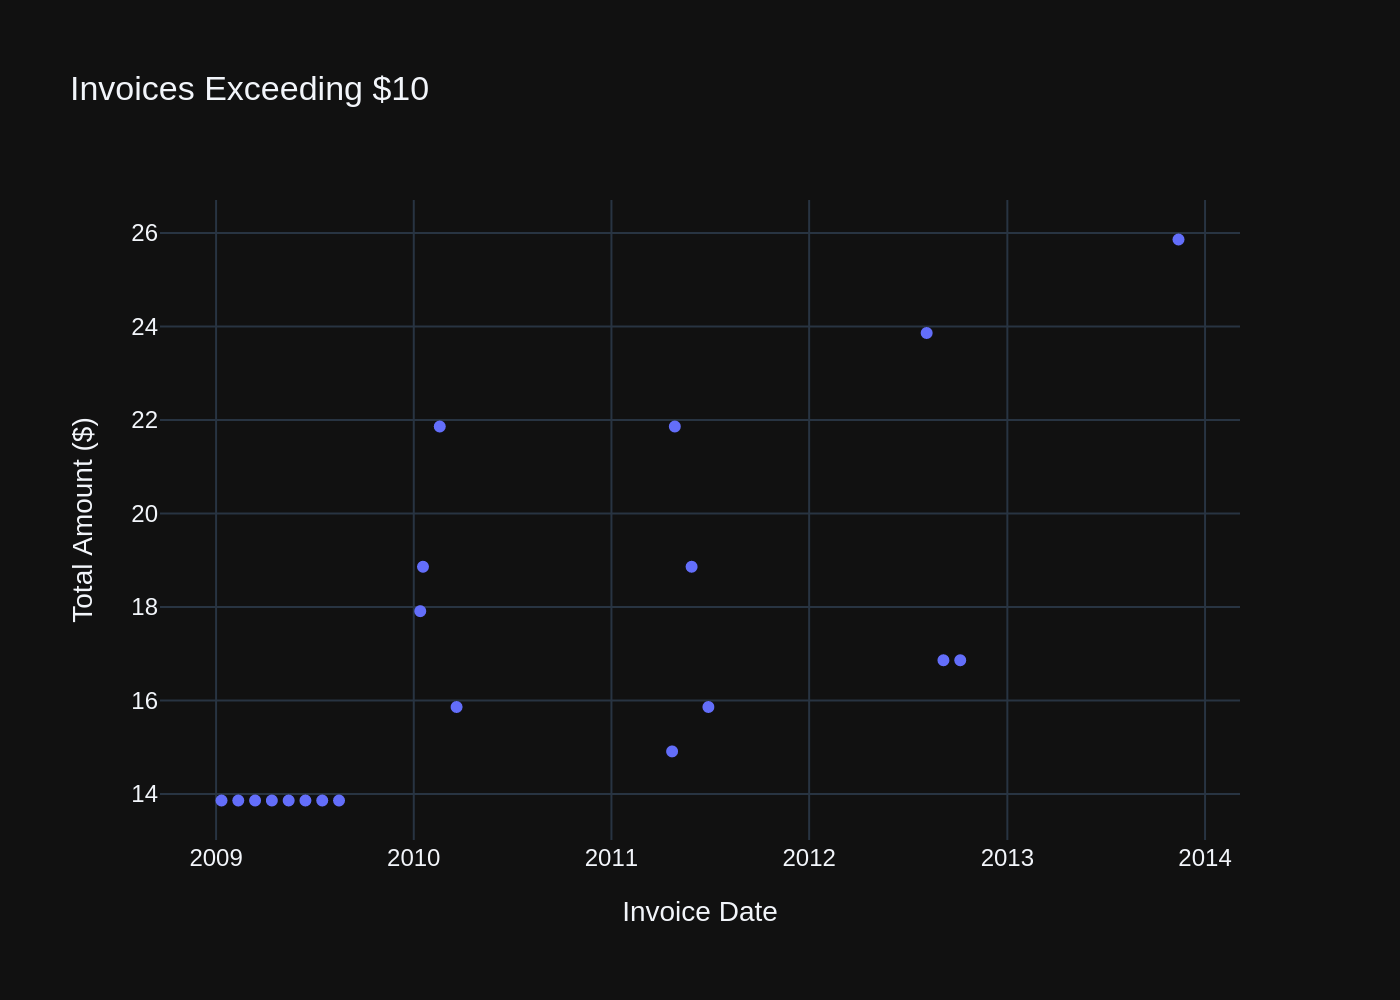





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model claude-3-5-sonnet-20241022 for 1154.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT COUNT(*) as invoice_count, 
       SUM(Total) as total_amount
FROM invoices 
WHERE InvoiceDate >= '2010-01-01' LIMIT 20


[( <DataFrame> )]
queried dataframe



,invoice_count,total_amount
0,329,1879.14


Using model claude-3-5-sonnet-20241022 for 198.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['total_amount'].iloc[0],
    title = {"text": "Total Amount Invoiced Since 2010"},
    number = {'prefix': "$"}
))

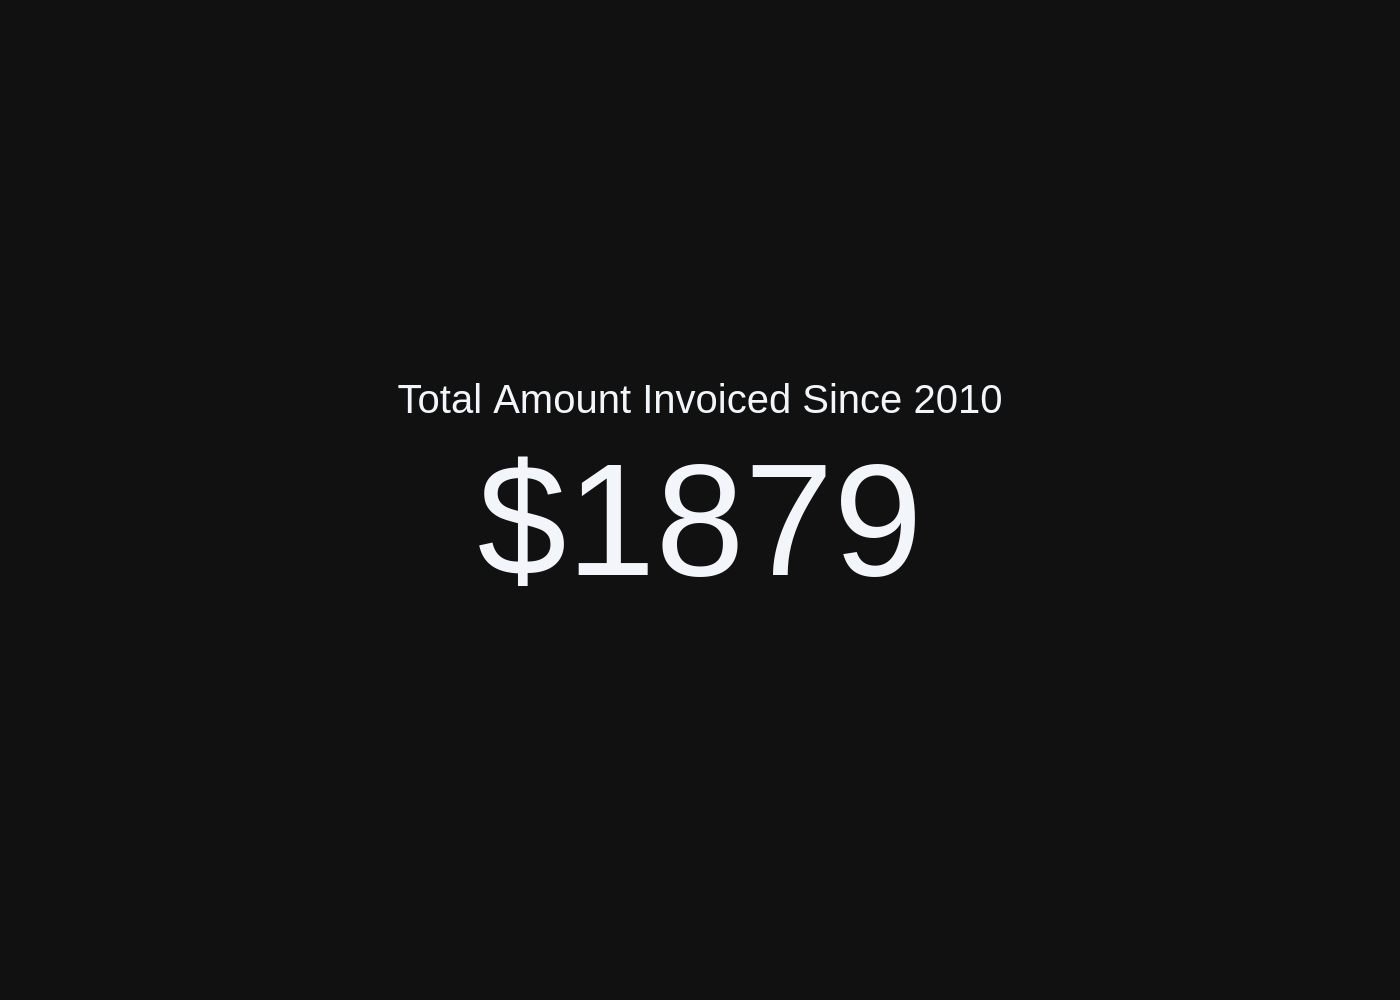





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model claude-3-5-sonnet-20241022 for 1199.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT e1.EmployeeId,
       e1.FirstName || ' ' || e1.LastName as Employee,
       e2.FirstName || ' ' || e2.LastName as Manager
FROM employees e1
LEFT JOIN employees e2 ON e1.ReportsTo = e2.EmployeeId
ORDER BY e1.EmployeeId


[( <DataFrame> )]
queried dataframe



,EmployeeId,Employee,Manager
0,1,Andrew Adams,None
1,2,Nancy Edwards,Andrew Adams
2,3,Jane Peacock,Nancy Edwards
3,4,Margaret Park,Nancy Edwards
4,5,Steve Johnson,Nancy Edwards
5,6,Michael Mitchell,Andrew Adams
6,7,Robert King,Michael Mitchell
7,8,Laura Callahan,Michael Mitchell


Using model claude-3-5-sonnet-20241022 for 230.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import plotly.express as px

fig = px.treemap(df, 
                 path=['Manager', 'Employee'],
                 title='Employee Reporting Structure')

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

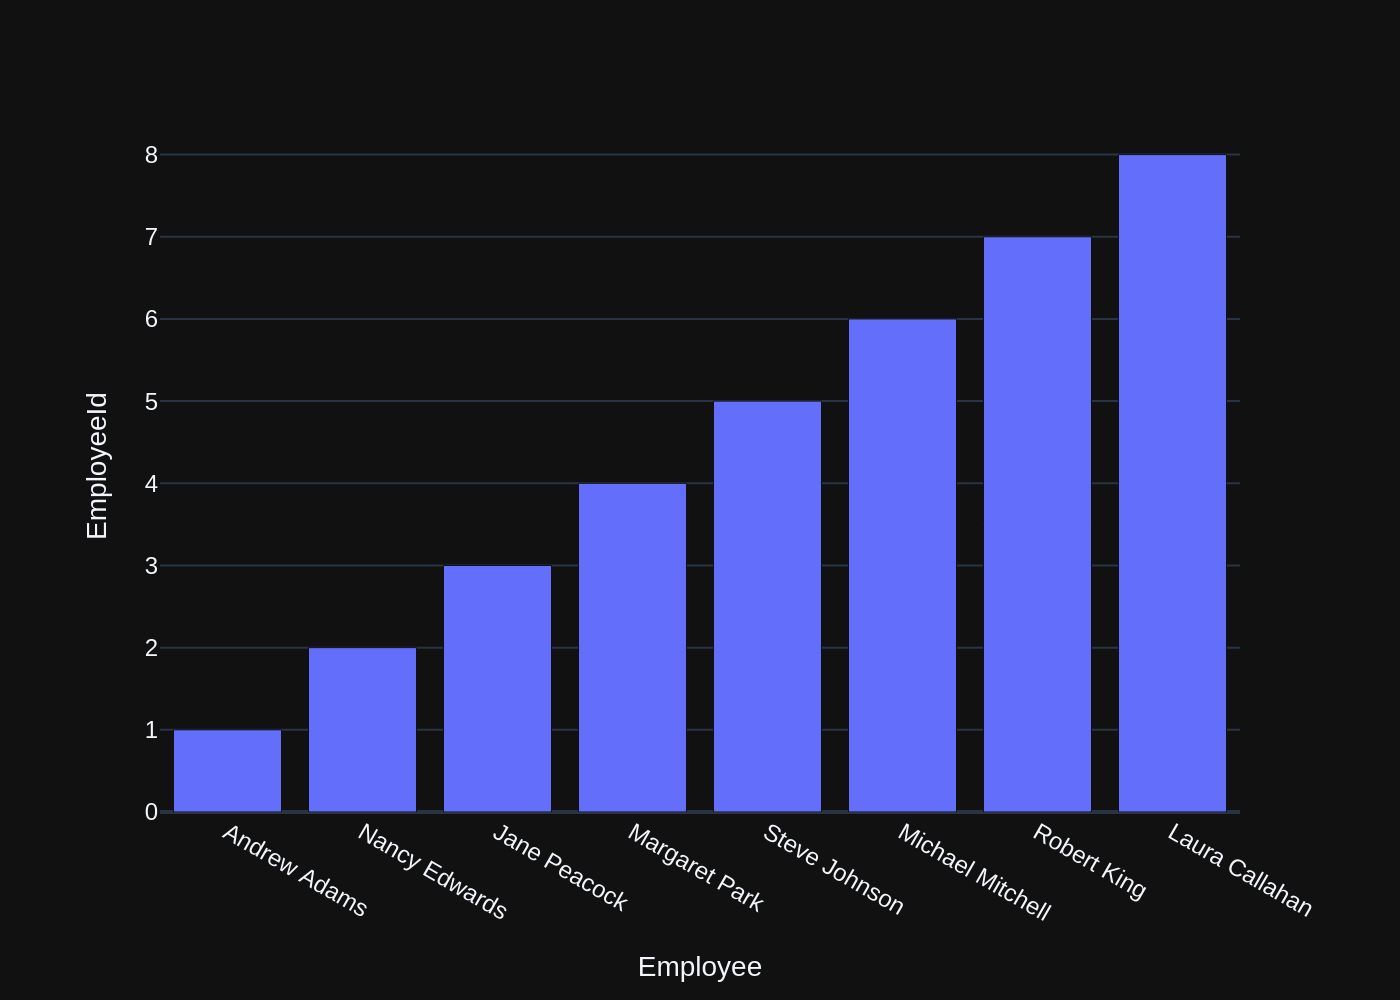





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model claude-3-5-sonnet-20241022 for 1141.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       AVG(i.Total) as avg_invoice_total
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY avg_invoice_total DESC LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,avg_invoice_total
0,6,Helena,Holý,7.088571
1,26,Richard,Cunningham,6.802857
2,57,Luis,Rojas,6.660000
3,45,Ladislav,Kovács,6.517143
4,46,Hugh,O'Reilly,6.517143
5,24,Frank,Ralston,6.231429
6,28,Julia,Barnett,6.231429
7,37,Fynn,Zimmermann,6.231429
8,59,Puja,Srivastava,6.106667
9,7,Astrid,Gruber,6.088571


Using model claude-3-5-sonnet-20241022 for 246.25 tokens (approx)

[( <Python> )]
generated Plotly code



fig = px.bar(df, 
             x='LastName', 
             y='avg_invoice_total',
             title='Average Invoice Total by Customer',
             labels={'avg_invoice_total': 'Average Invoice Total ($)',
                    'LastName': 'Customer Last Name'},
             text=round(df['avg_invoice_total'], 2))

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=45,
    showlegend=False
)

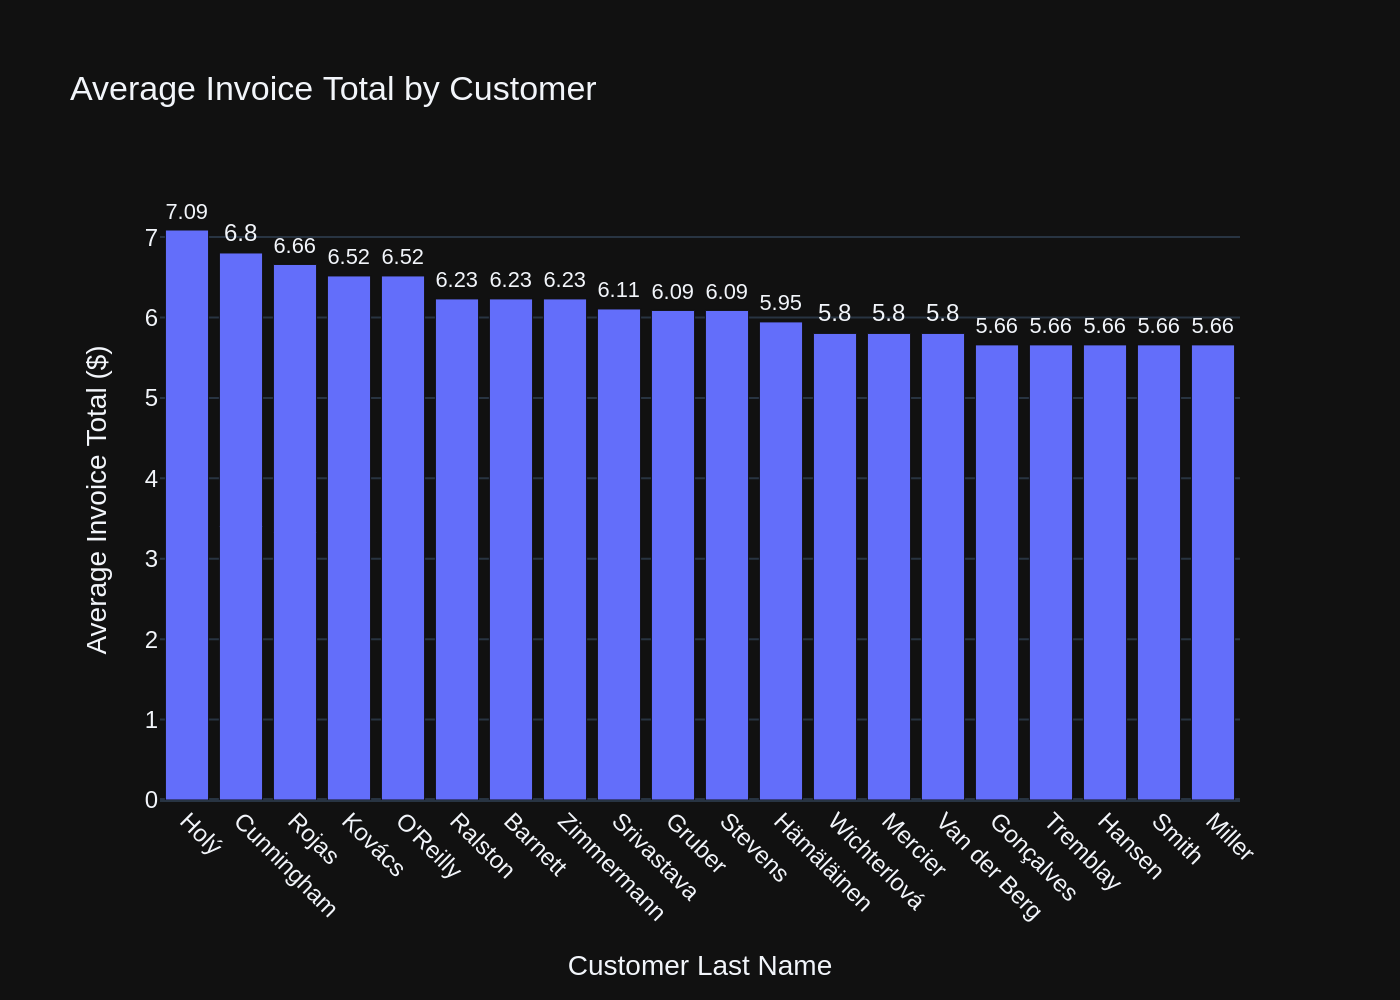





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model claude-3-5-sonnet-20241022 for 1138.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Name, UnitPrice
FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,Name,UnitPrice
0,Battlestar Galactica: The Story So Far,1.99
1,Occupation / Precipice,1.99
2,"Exodus, Pt. 1",1.99
3,"Exodus, Pt. 2",1.99
4,Collaborators,1.99


Using model claude-3-5-sonnet-20241022 for 181.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Name', y='UnitPrice', title='Top 5 Most Expensive Tracks')
fig.update_layout(xaxis_title='Track Name', yaxis_title='Unit Price ($)')

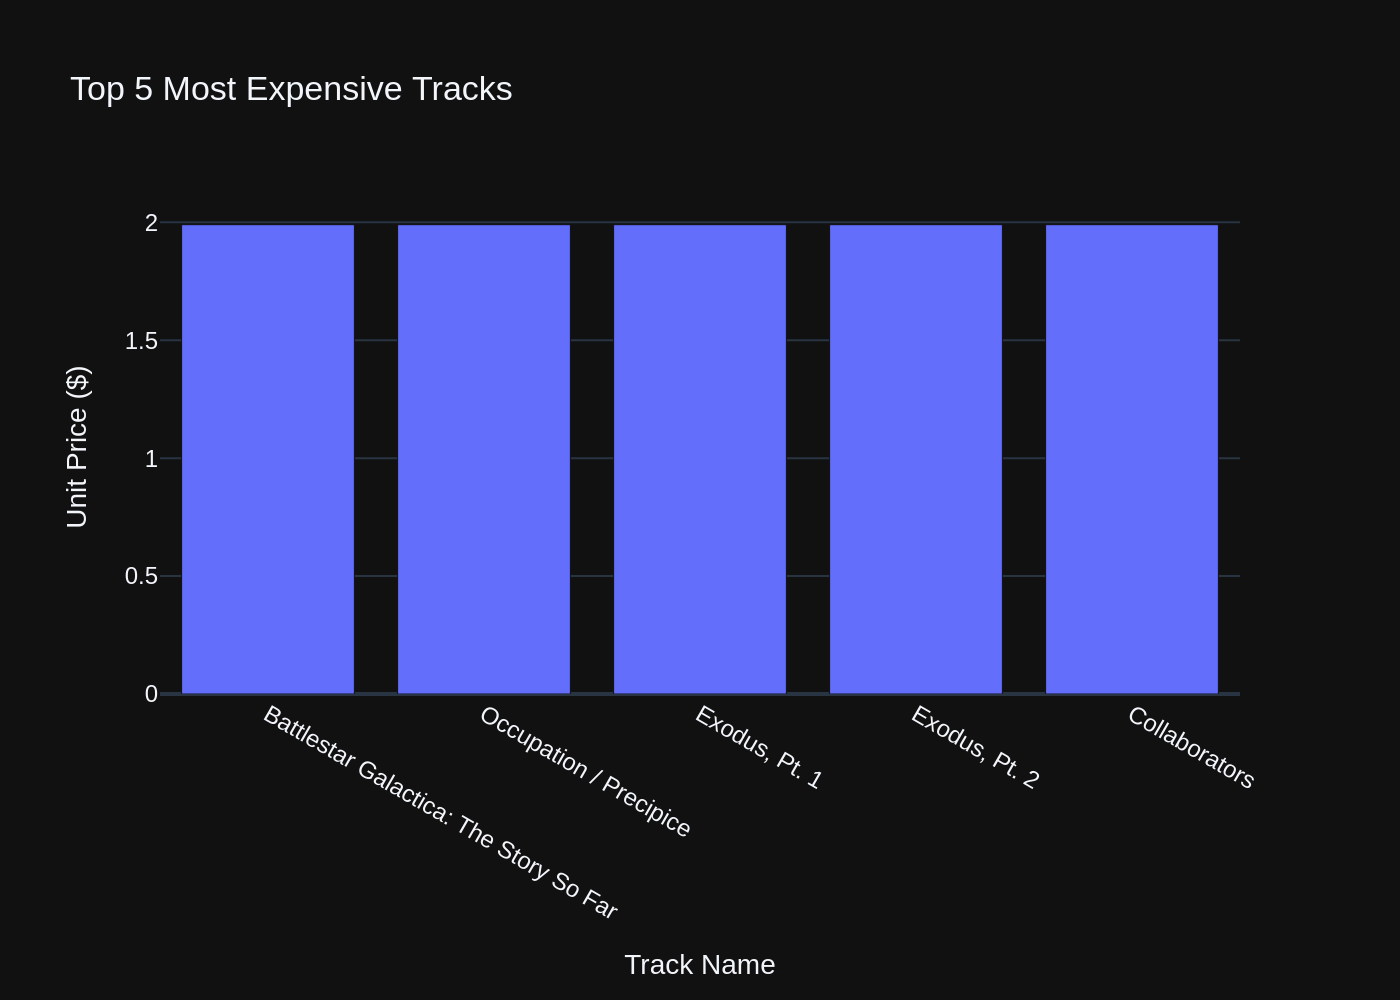





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model claude-3-5-sonnet-20241022 for 1102.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name as genre_name, 
       COUNT(t.TrackId) as track_count
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY track_count DESC


[( <DataFrame> )]
queried dataframe



,genre_name,track_count
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130
5,TV Shows,93
6,Blues,81
7,Classical,74
8,Drama,64
9,R&B/Soul,61


Using model claude-3-5-sonnet-20241022 for 211.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='genre_name', y='track_count', 
             title='Number of Tracks by Genre',
             labels={'genre_name': 'Genre', 'track_count': 'Number of Tracks'})
fig.update_layout(showlegend=False)
fig.update_xaxis(tickangle=45)

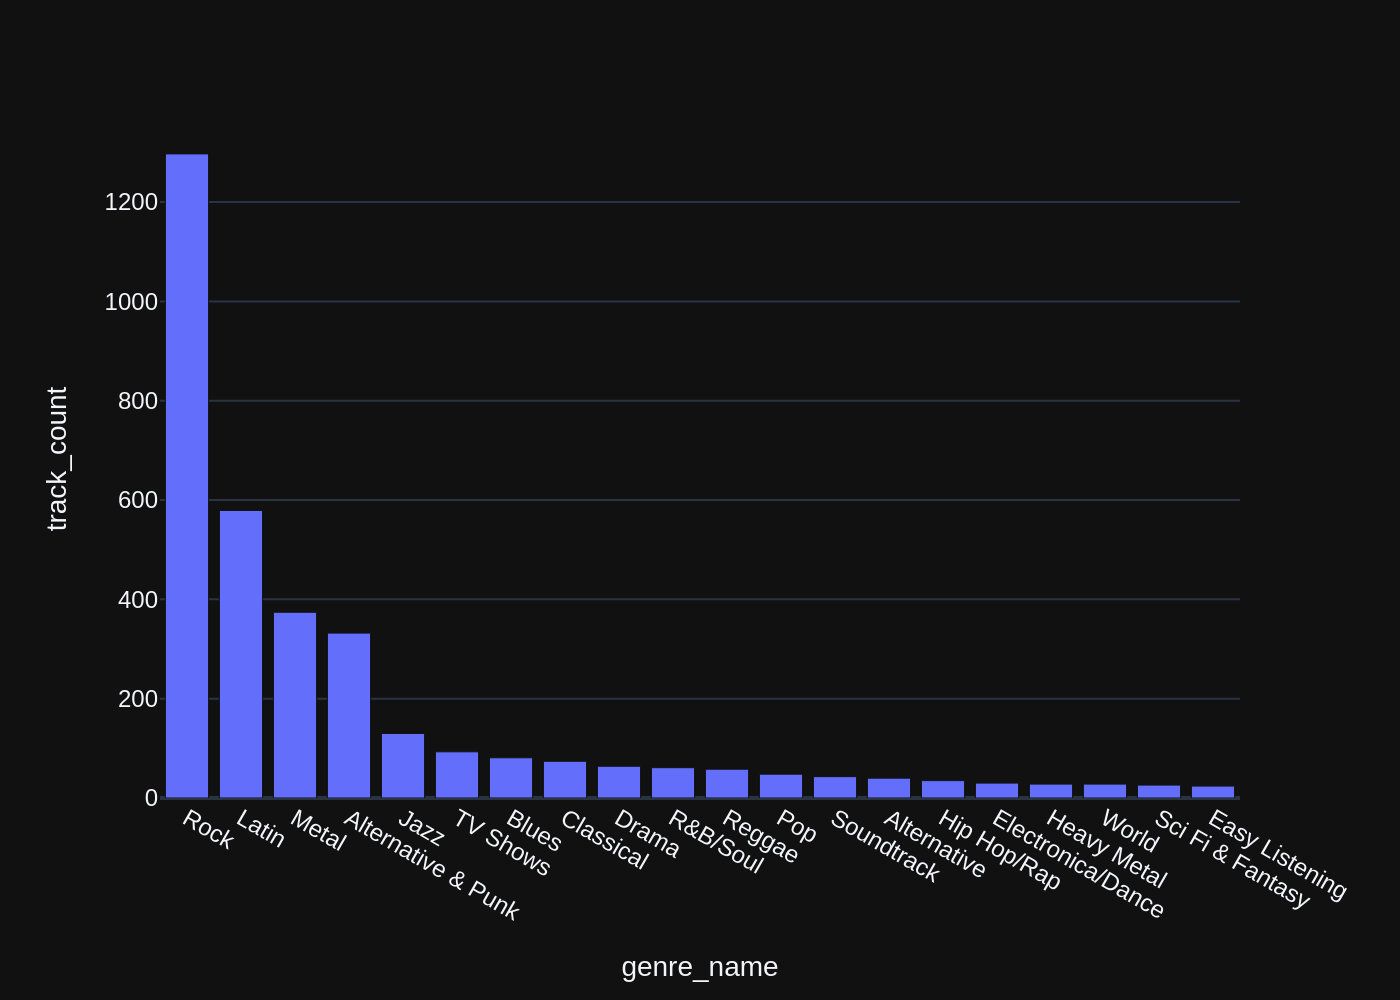





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model claude-3-5-sonnet-20241022 for 1140.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 1 *****

Using model claude-3-5-sonnet-20241022 for 1326.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 2 *****

Using model claude-3-5-sonnet-20241022 for 1273.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 3 *****

Using model claude-3-5-sonnet-20241022 for 1368.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL


[( <DataFrame> )]
queried dataframe



,Name






# QUESTION  - 17:  List all customers who have not placed any orders:


Using model claude-3-5-sonnet-20241022 for 1284.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       c.Email
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Email



[( RETRY )]
***** 1 *****

Using model claude-3-5-sonnet-20241022 for 1366.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL
ORDER BY c.CustomerId


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName



[( RETRY )]
***** 2 *****

Using model claude-3-5-sonnet-20241022 for 1424.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, c.Email
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL
ORDER BY c.CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Email



[( RETRY )]
***** 3 *****

Using model claude-3-5-sonnet-20241022 for 1469.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       c.Email
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL
ORDER BY c.CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Email






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model claude-3-5-sonnet-20241022 for 1161.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT ar.Name as artist_name, 
       COUNT(t.TrackId) as track_count
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, ar.Name
ORDER BY track_count DESC
LIMIT 10


[( <DataFrame> )]
queried dataframe



,artist_name,track_count
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model claude-3-5-sonnet-20241022 for 272.75 tokens (approx)

[( <Python> )]
generated Plotly code



fig = px.bar(df, 
             x='artist_name', 
             y='track_count',
             title='Top 10 Artists by Number of Tracks',
             labels={'artist_name': 'Artist Name', 
                    'track_count': 'Number of Tracks'})

fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False
)

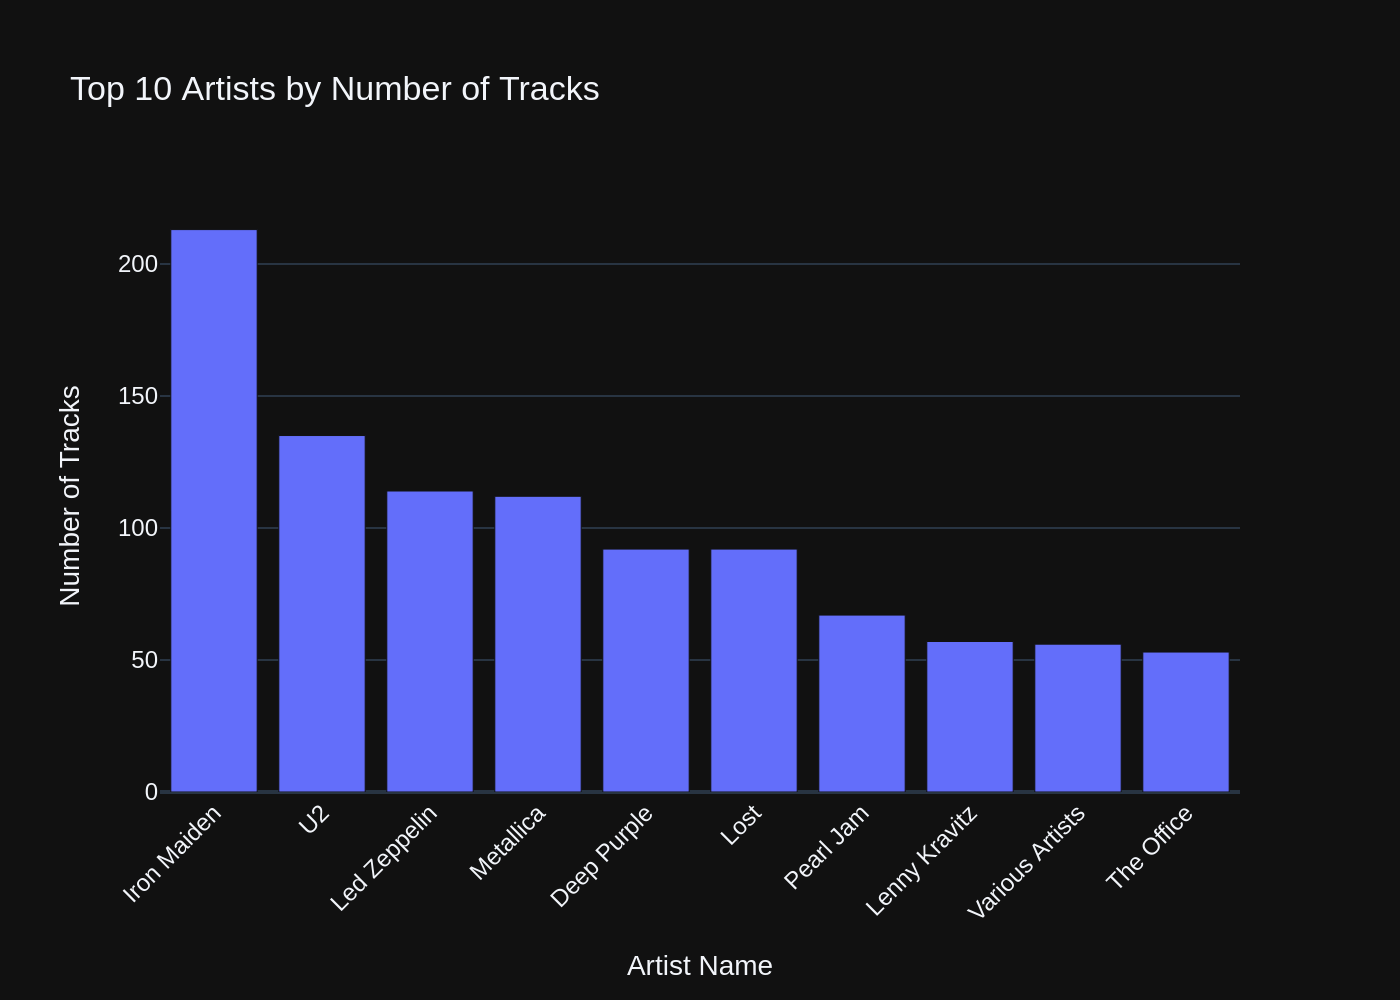





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model claude-3-5-sonnet-20241022 for 1257.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada'
ORDER BY LastName, FirstName LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,Robert,Brown,robbrown@shaw.ca
1,Edward,Francis,edfrancis@yachoo.ca
2,Aaron,Mitchell,aaronmitchell@yahoo.ca
3,Jennifer,Peterson,jenniferp@rogers.ca
4,Mark,Philips,mphilips12@shaw.ca
5,Martha,Silk,marthasilk@gmail.com
6,Ellie,Sullivan,ellie.sullivan@shaw.ca
7,François,Tremblay,ftremblay@gmail.com


Using model claude-3-5-sonnet-20241022 for 197.0 tokens (approx)

[( <Python> )]
generated Plotly code



# Since this data is a list of names/emails, a table visualization makes more sense than a chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.FirstName, df.LastName, df.Email],
               fill_color='lavender',
               align='left'))
])

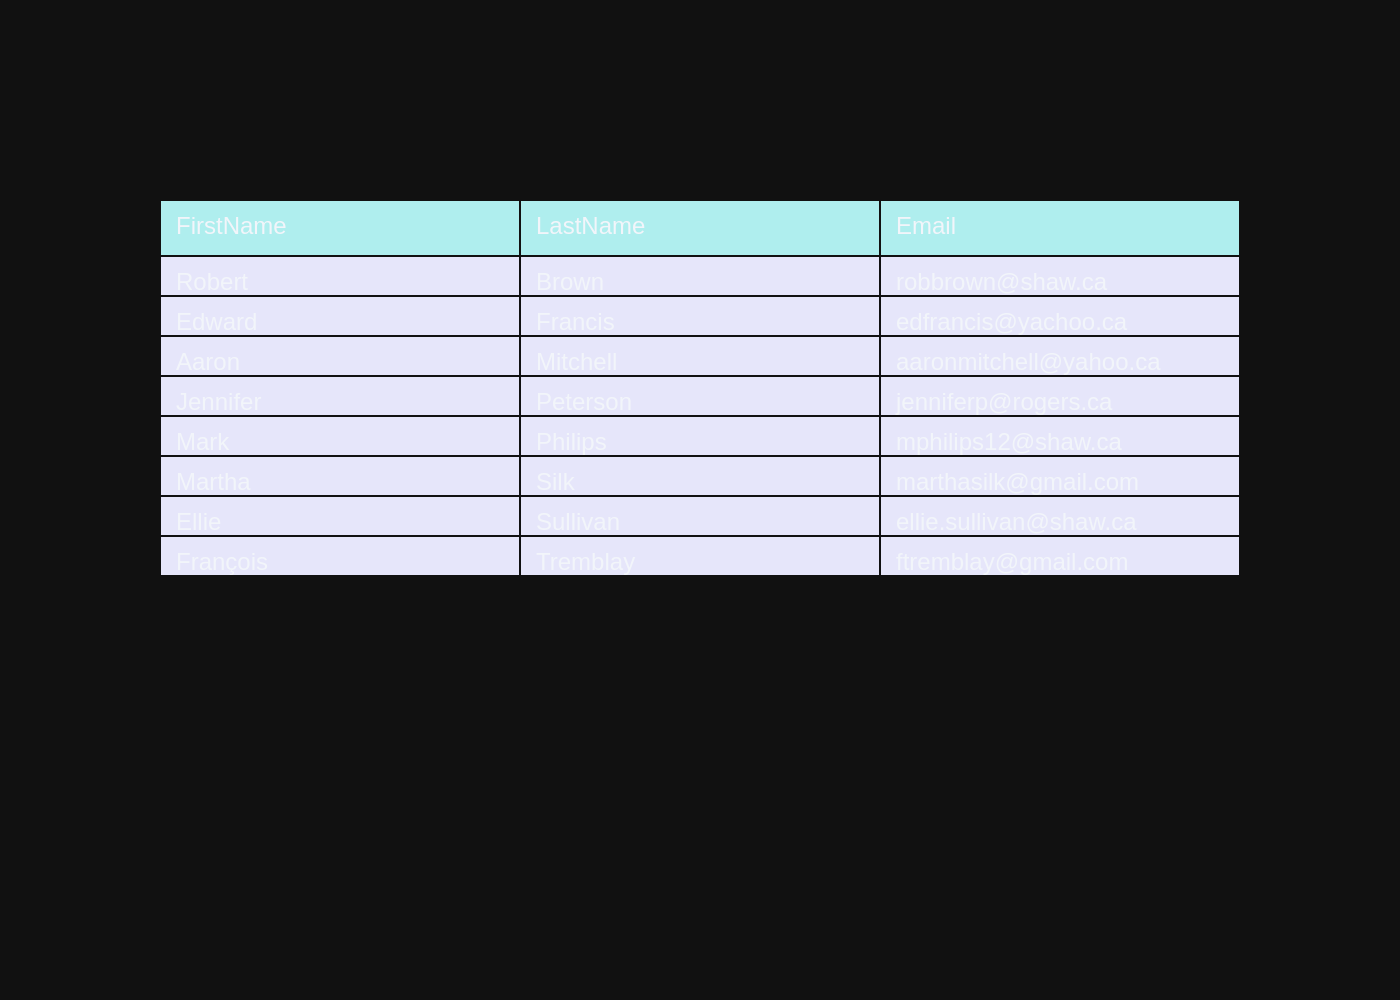





# QUESTION  - 20:  Find the customer with the most invoices 


Using model claude-3-5-sonnet-20241022 for 1184.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       COUNT(i.InvoiceId) as invoice_count
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY invoice_count DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,invoice_count
0,1,Luís,Gonçalves,7


Using model claude-3-5-sonnet-20241022 for 237.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['invoice_count'].iloc[0],
    title = {"text": f"Most Invoices by {df['FirstName'].iloc[0]} {df['LastName'].iloc[0]}"}
))

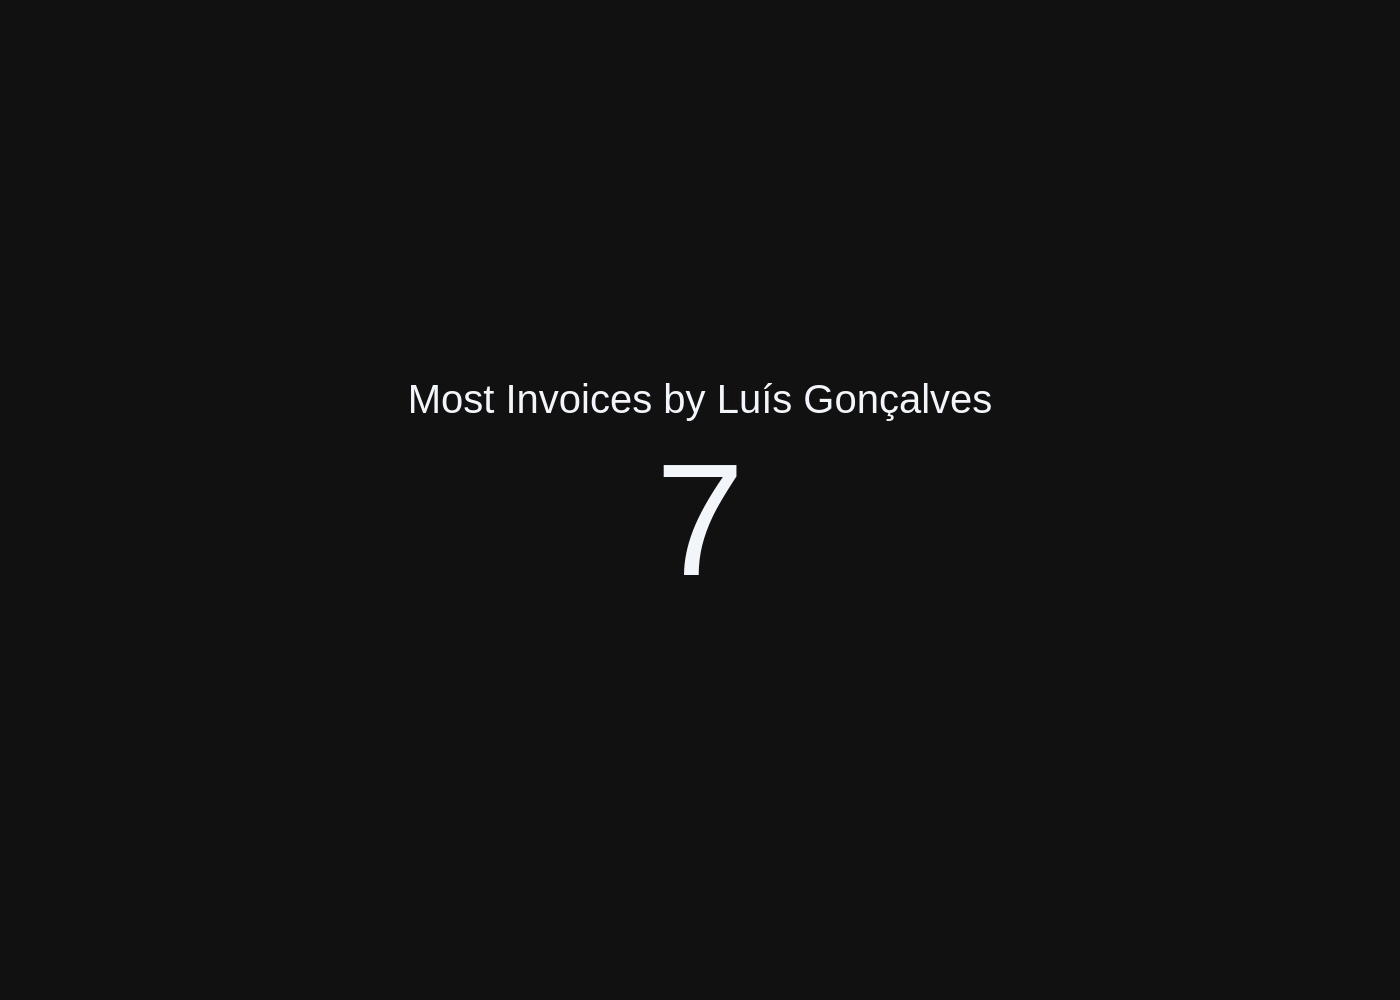





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model claude-3-5-sonnet-20241022 for 1327.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       SUM(ii.Quantity) as total_albums_bought
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_albums_bought DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_albums_bought
0,1,Luís,Gonçalves,38


Using model claude-3-5-sonnet-20241022 for 269.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['total_albums_bought'].iloc[0],
    title = {"text": f"Most Albums Bought by {df['FirstName'].iloc[0]} {df['LastName'].iloc[0]}"}
))

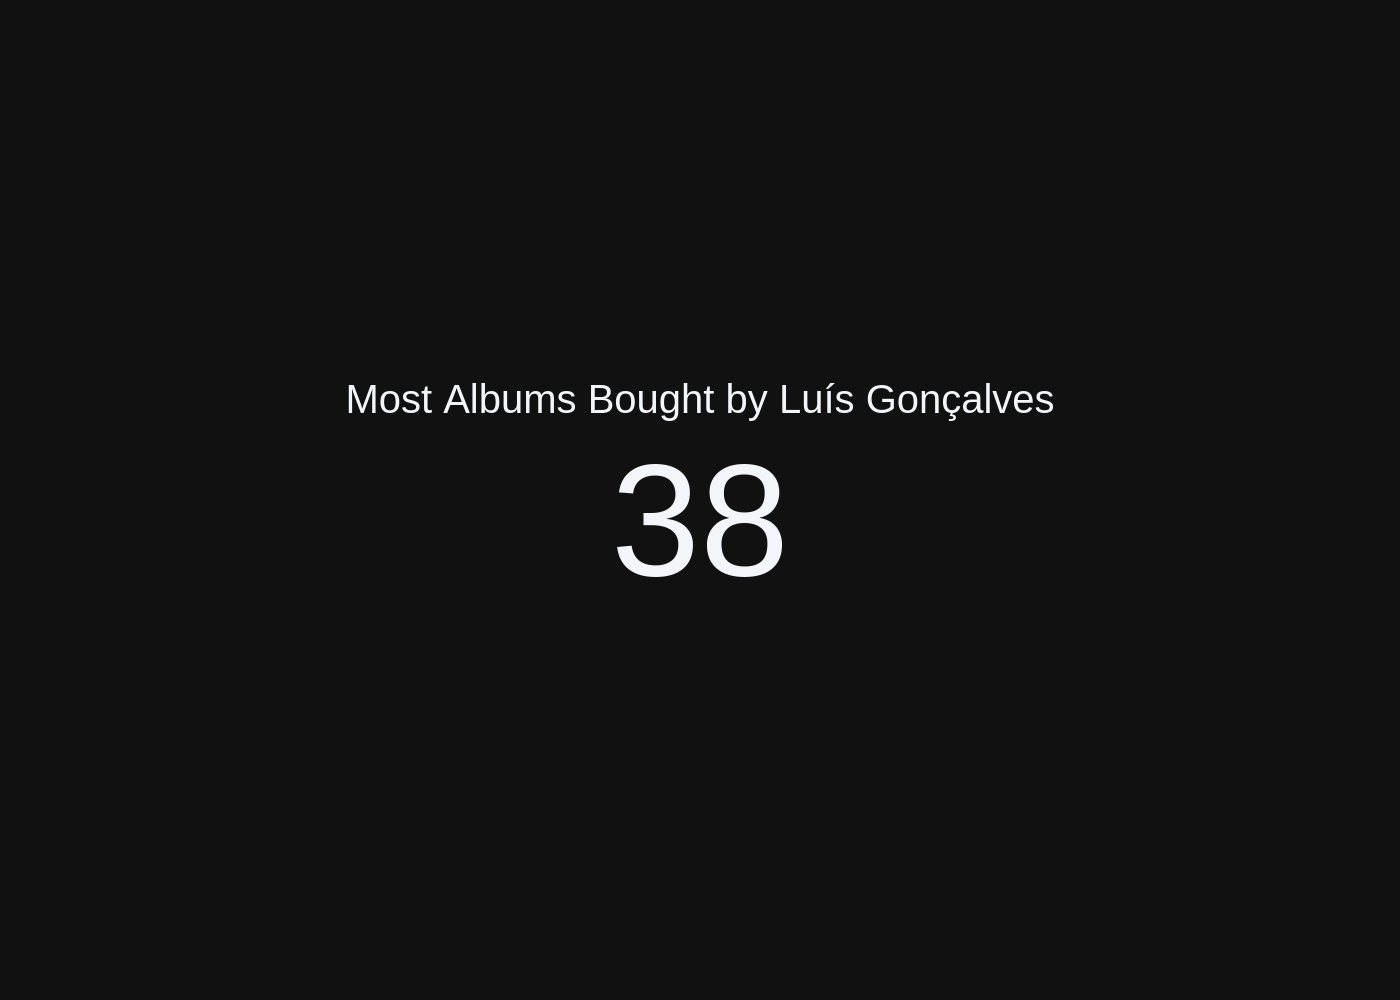





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model claude-3-5-sonnet-20241022 for 1384.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       SUM(ii.Quantity) as total_albums_bought
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_albums_bought DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_albums_bought
0,1,Luís,Gonçalves,38
1,2,Leonie,Köhler,38
2,3,François,Tremblay,38
3,4,Bjørn,Hansen,38
4,5,František,Wichterlová,38


Using model claude-3-5-sonnet-20241022 for 290.75 tokens (approx)

[( <Python> )]
generated Plotly code



fig = go.Figure(data=[
    go.Bar(
        x=df['FirstName'] + ' ' + df['LastName'],
        y=df['total_albums_bought'],
        text=df['total_albums_bought'],
        textposition='auto',
    )
])

fig.update_layout(
    title='Top 5 Customers by Total Albums Purchased',
    xaxis_title='Customer Name',
    yaxis_title='Total Albums Bought',
    showlegend=False
)

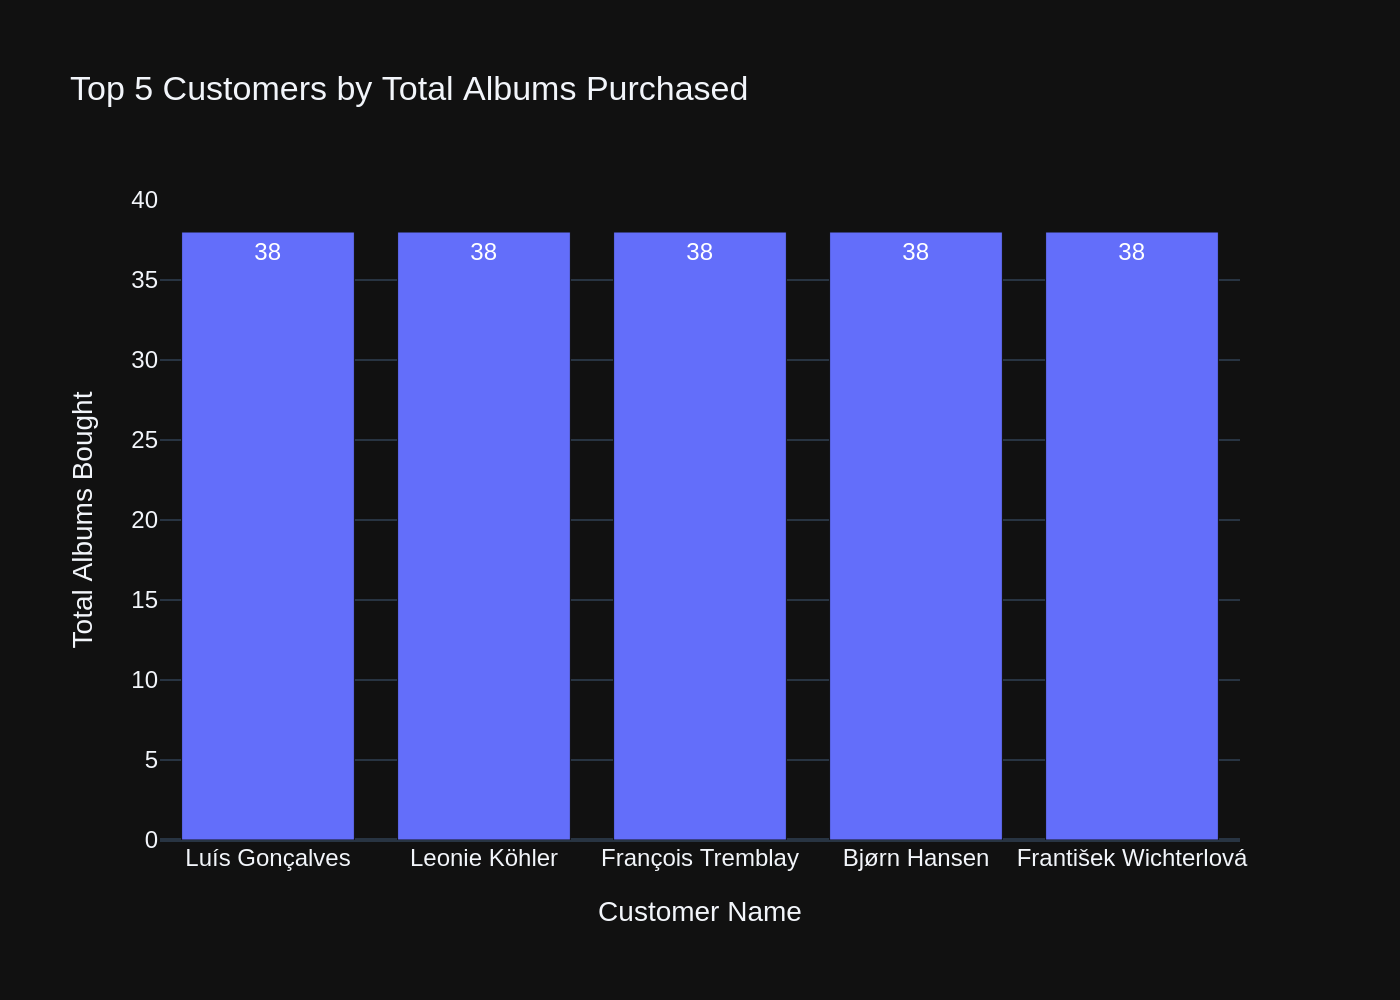





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model claude-3-5-sonnet-20241022 for 1382.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, 
       c.FirstName, 
       c.LastName, 
       SUM(i.Total) as total_spent
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_spent DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_spent
0,6,Helena,Holý,49.62
1,26,Richard,Cunningham,47.62
2,57,Luis,Rojas,46.62
3,45,Ladislav,Kovács,45.62
4,46,Hugh,O'Reilly,45.62


Using model claude-3-5-sonnet-20241022 for 272.75 tokens (approx)

[( <Python> )]
generated Plotly code



fig = go.Figure(data=[
    go.Bar(
        x=df['FirstName'] + ' ' + df['LastName'],
        y=df['total_spent'],
        text=df['total_spent'].round(2),
        textposition='auto',
    )
])

fig.update_layout(
    title='Top 5 Customers by Total Spend',
    xaxis_title='Customer Name',
    yaxis_title='Total Amount Spent ($)',
    showlegend=False
)

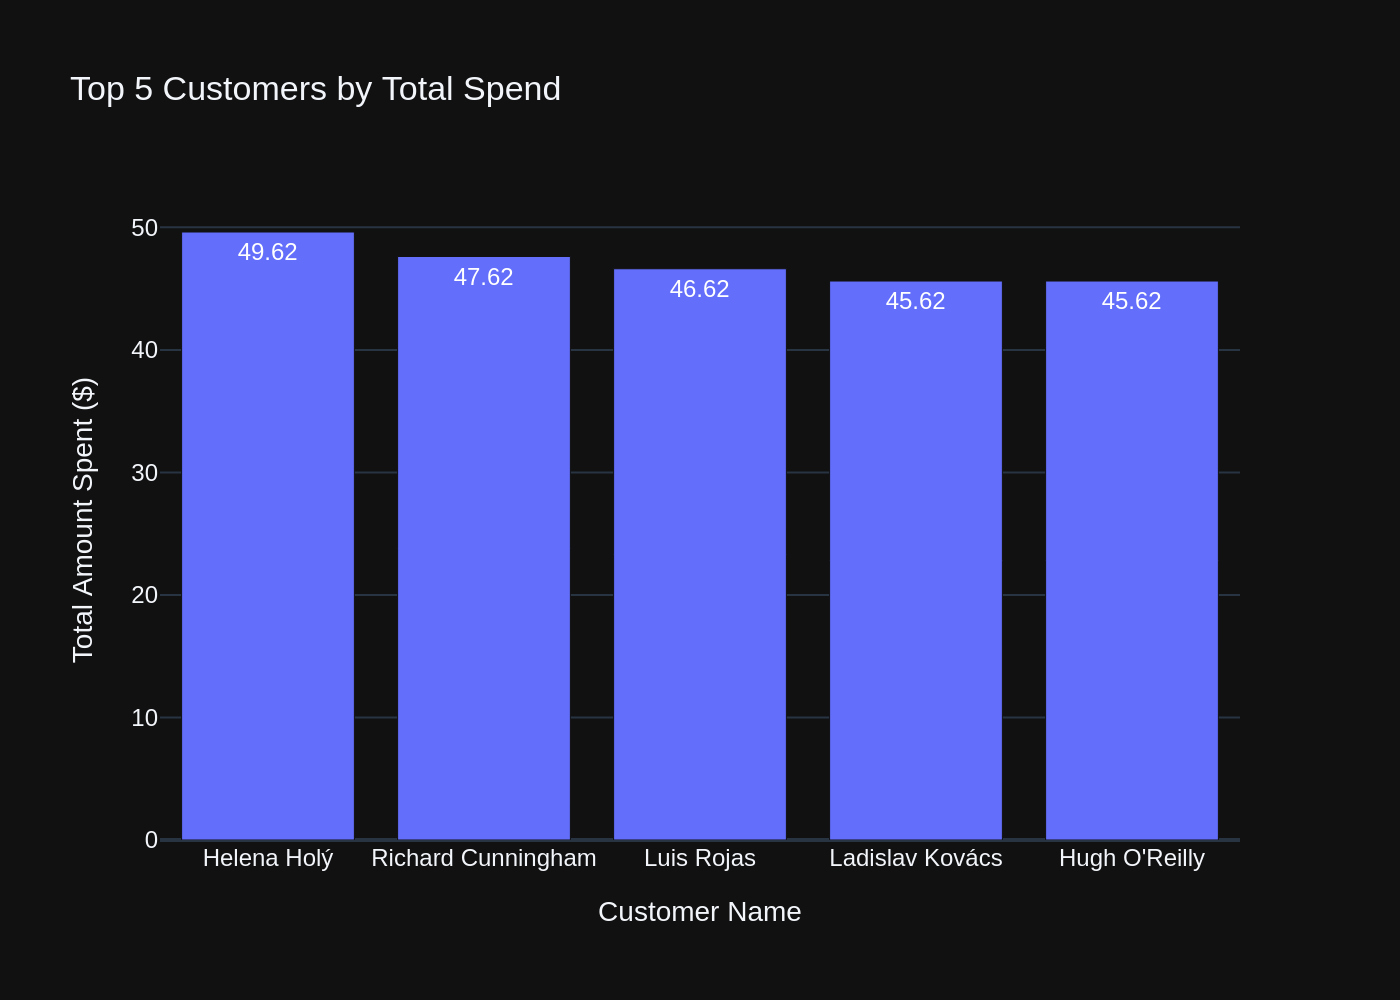





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model claude-3-5-sonnet-20241022 for 1332.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT p.PlaylistId, 
       p.Name, 
       COUNT(t.TrackId) as track_count,
       SUM(t.Milliseconds)/1000 as total_duration_seconds
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId, p.Name
HAVING COUNT(t.TrackId) >= 10
ORDER BY track_count DESC


[( <DataFrame> )]
queried dataframe



,PlaylistId,Name,track_count,total_duration_seconds
0,1,Music,3290,877683
1,8,Music,3290,877683
2,5,90’s Music,1477,398705
3,3,TV Shows,213,501094
4,10,TV Shows,213,501094
5,12,Classical,75,21770
6,11,Brazilian Music,39,9486
7,17,Heavy Metal Classic,26,8206
8,13,Classical 101 - Deep Cuts,25,6755
9,14,Classical 101 - Next Steps,25,7575


Using model claude-3-5-sonnet-20241022 for 280.25 tokens (approx)

[( <Python> )]
generated Plotly code



fig = go.Figure()

fig.add_trace(go.Bar(
    x=df['Name'],
    y=df['track_count'],
    name='Track Count',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=df['Name'],
    y=df['total_duration_seconds'],
    name='Duration (seconds)',
    yaxis='y2'
))

fig.update_layout(
    title='Playlist Analysis: Track Count and Duration',
    yaxis=dict(title='Track Count', side='left'),
    yaxis2=dict(title='Duration (seconds)', side='right', overlaying='y'),
    barmode='group',
    height=600,
    showlegend=True
)

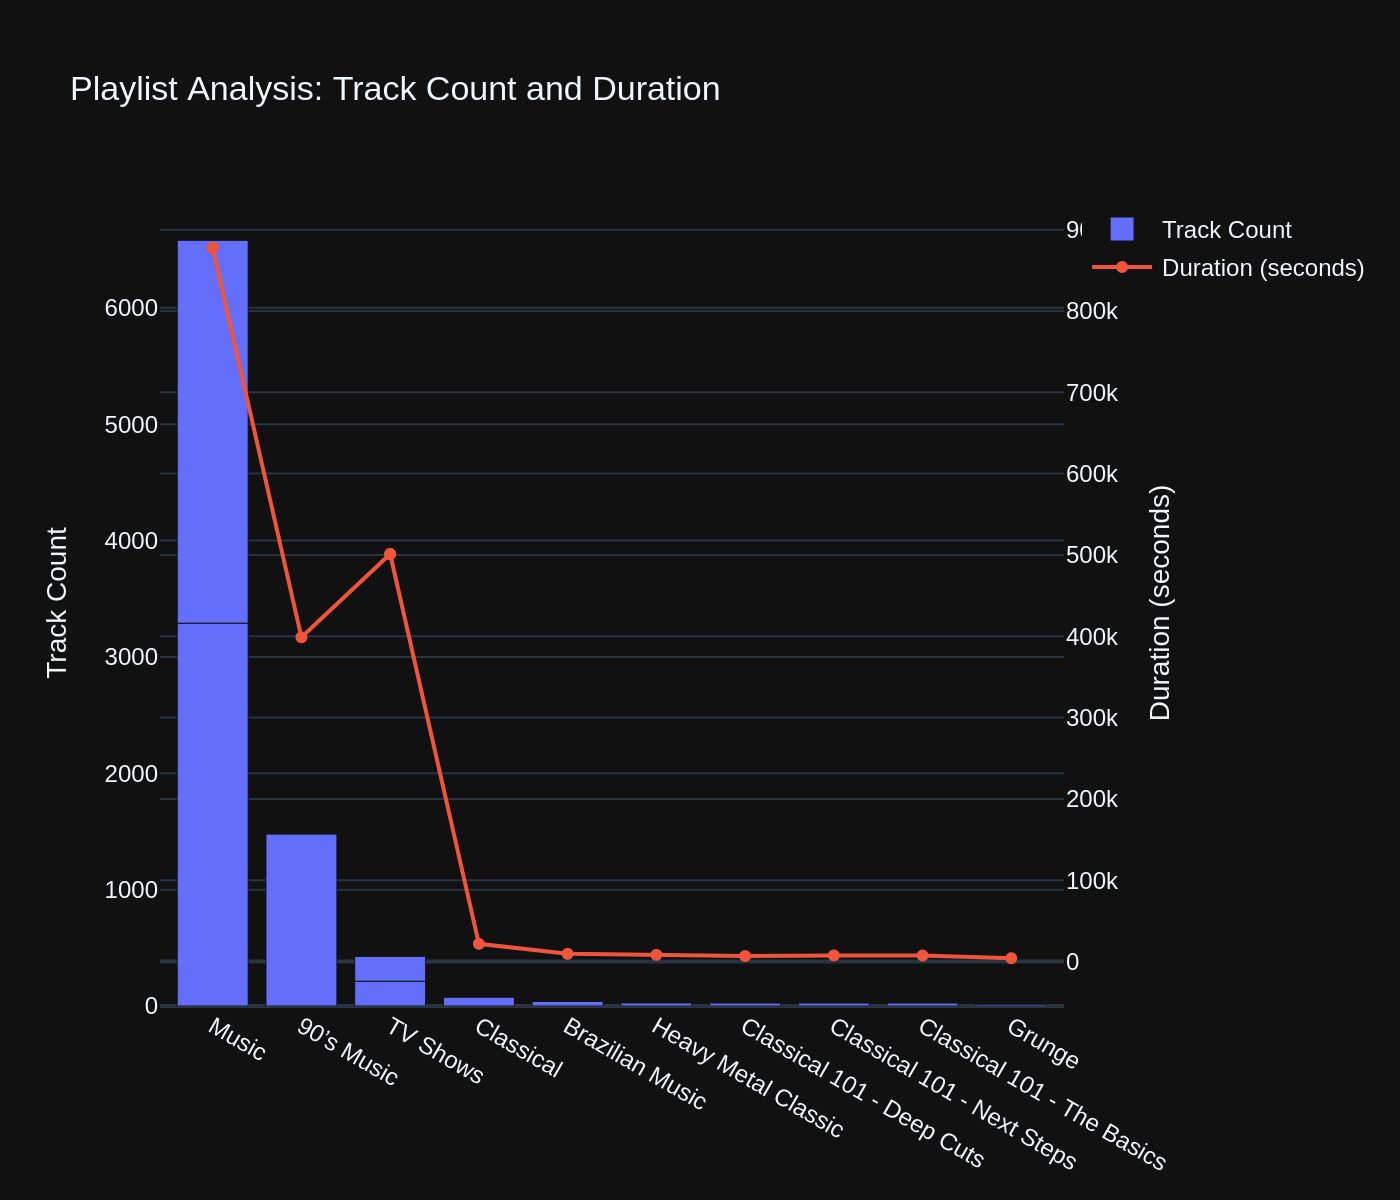





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model claude-3-5-sonnet-20241022 for 1355.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT DISTINCT ar.ArtistId, 
       ar.Name as artist_name,
       COUNT(DISTINCT t.GenreId) as number_of_genres
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, ar.Name
HAVING COUNT(DISTINCT t.GenreId) > 1
ORDER BY number_of_genres DESC


[( <DataFrame> )]
queried dataframe



,ArtistId,artist_name,number_of_genres
0,90,Iron Maiden,4
1,8,Audioslave,3
2,21,Various Artists,3
3,27,Gilberto Gil,3
4,92,Jamiroquai,3
5,100,Lenny Kravitz,3
6,147,Battlestar Galactica,3
7,6,Antônio Carlos Jobim,2
8,81,Eric Clapton,2
9,82,Faith No More,2


Using model claude-3-5-sonnet-20241022 for 258.75 tokens (approx)

[( <Python> )]
generated Plotly code



fig = px.bar(df, 
             x='artist_name', 
             y='number_of_genres',
             title='Artists by Number of Different Genres',
             labels={'artist_name': 'Artist Name',
                    'number_of_genres': 'Number of Genres'})

fig.update_layout(
    xaxis_tickangle=45,
    showlegend=False
)

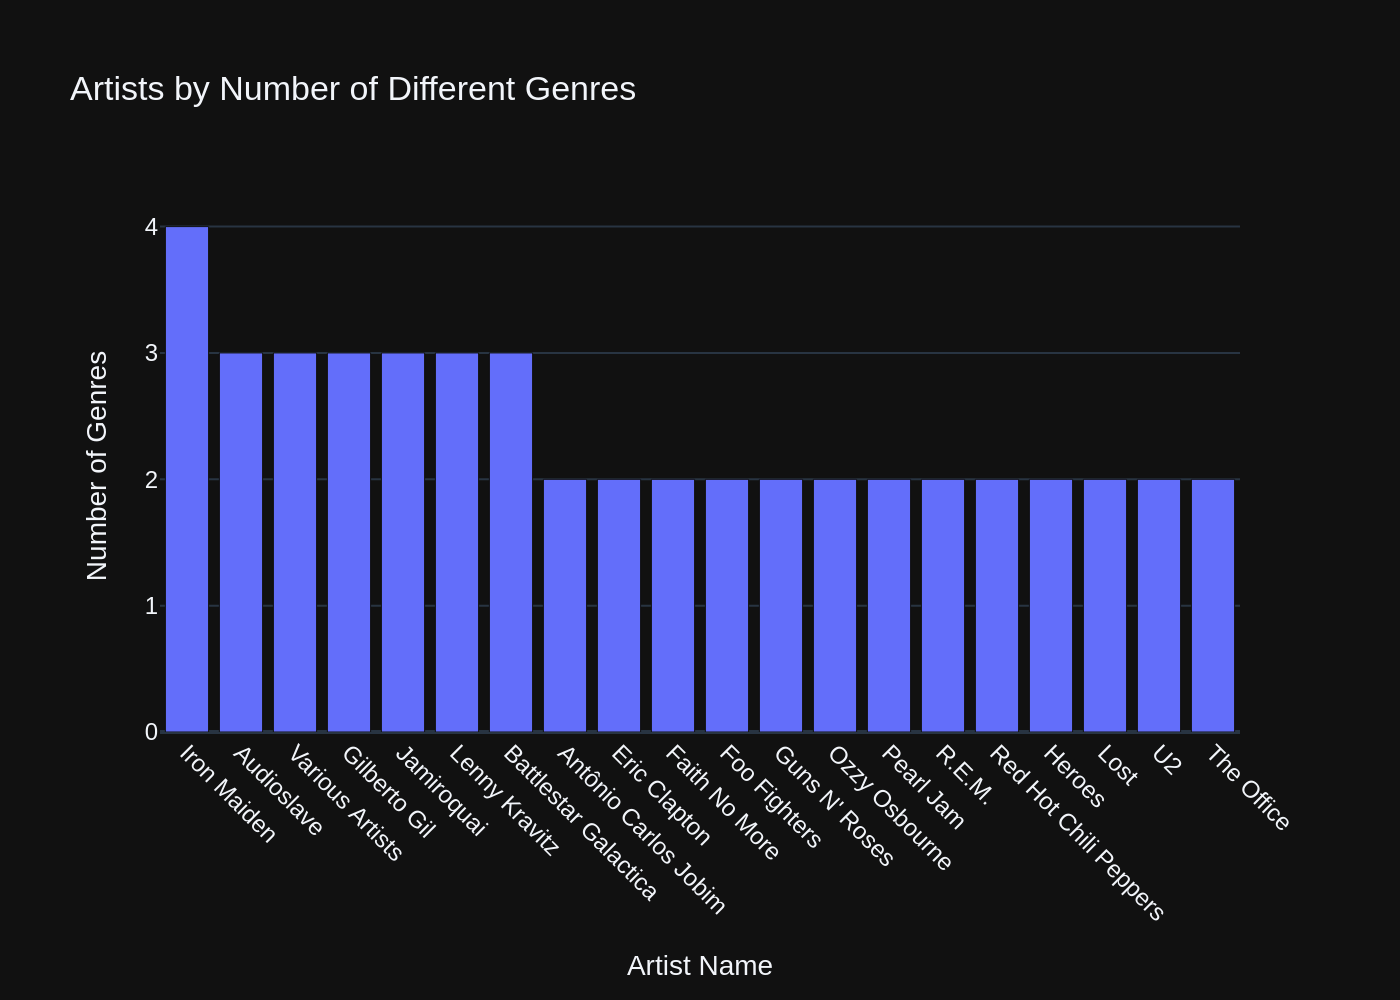

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'claude-3-5-sonnet-20241022' 
 took 149 sec
 run on 'ducklover1' 
 at 20241122-232143


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-claude-3-5-sonnet-20241022-149s-ducklover1-20241122-232143.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,12dd59f0-d021-5c6d-a453-190e908eae78-sql,List all invoices with a total exceeding $10,"SELECT InvoiceId, CustomerId, InvoiceDate, Tot...",sql
1,239975a3-a817-5e85-bf5c-da2a315545ec-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
2,3b38f7cc-48b3-5679-86f7-ccd7d00ef1c2-sql,\n Find the top 5 customers who b...,"SELECT c.CustomerId, \n c.FirstName, \n ...",sql
3,3ed67005-3b35-5b85-85a5-a0256ecb4b33-sql,List all genres and the number of tracks in ea...,"SELECT g.Name as genre_name, \n COUNT(t....",sql
4,411d1ca7-609d-5ae7-ae0c-f9d618c51479-sql,List all albums and their corresponding artist...,"SELECT a.Title as album_title, ar.Name as arti...",sql
5,45ec8642-c9df-5f7c-9db7-a3e49ffeb99b-sql,Find all invoices since 2010 and the total amo...,"SELECT COUNT(*) as invoice_count, \n SUM...",sql
6,623f1c4c-8b2b-5bbf-a7c3-6d8aa4721624-sql,"Find all tracks with a name containing ""What"" ...",SELECT Name \nFROM tracks \nWHERE UPPER(Name) ...,sql
7,695e5b81-3c5e-5122-8ec5-e8d8835aa99a-sql,Get the average invoice total for each customer:,"SELECT c.CustomerId, \n c.FirstName, \n ...",sql
8,6cd9e404-f70d-5f77-882c-4718fce6ee6c-sql,\n Generating SQL for this ...,SELECT 'invoices' as table_name \nFROM sqlite_...,sql
9,6fd13857-bd8b-5214-a162-9a62d2484f30-sql,How many customers are there,SELECT COUNT(*) \nFROM customers LIMIT 20,sql


In [22]:
df_training_data.to_csv(file_csv, index=False)